# Nighttime Lights in Myanmar


**Data & Methodology Note:**


This notebook uses VIIRS Nighttime Lights Collection 2 monthly and annual products. For all analyses and visualizations where the year 2025 is shown, monthly data are aggregated to the annual level to ensure completeness, as the official annual product for 2025 may not be available yet. All other years use the official annual product where possible.

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from pathlib import Path
import glob
from wbpyplot import wb_plot

In [179]:
# Import visualization functions
%load_ext autoreload
%autoreload 2  
# sys.path.append('../../../src/')
from visuals import *
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
DATA_FOLDER = Path("../../../data/")
NTL_FOLDER = DATA_FOLDER / "ntl" / "collection2"
print(NTL_FOLDER)

../../../data/ntl/collection2


In [148]:
ntl_annual_adm0 = pd.read_csv(NTL_FOLDER / "annual/mmr_adm0_annual.csv")
ntl_annual_adm1 = pd.read_csv(NTL_FOLDER / "annual/mmr_adm1_annual.csv")

ntl_monthly_adm0 = pd.read_csv(NTL_FOLDER / "monthly/mmr_adm0_monthly.csv")
ntl_monthly_adm1 = pd.read_csv(NTL_FOLDER / "monthly/mmr_adm1_monthly.csv")

In [149]:
ntl_monthly_ind_5km = pd.read_csv(NTL_FOLDER / "monthly/mmr_induszone_5km_monthly.csv")
ntl_monthly_ind_10km = pd.read_csv(NTL_FOLDER / "monthly/mmr_induszone_10km_monthly.csv")

ntl_annual_ind_5km = pd.read_csv(NTL_FOLDER / "annual/mmr_induszone_5km_annual.csv")
ntl_annual_ind_10km = pd.read_csv(NTL_FOLDER / "annual/mmr_induszone_10km_annual.csv")

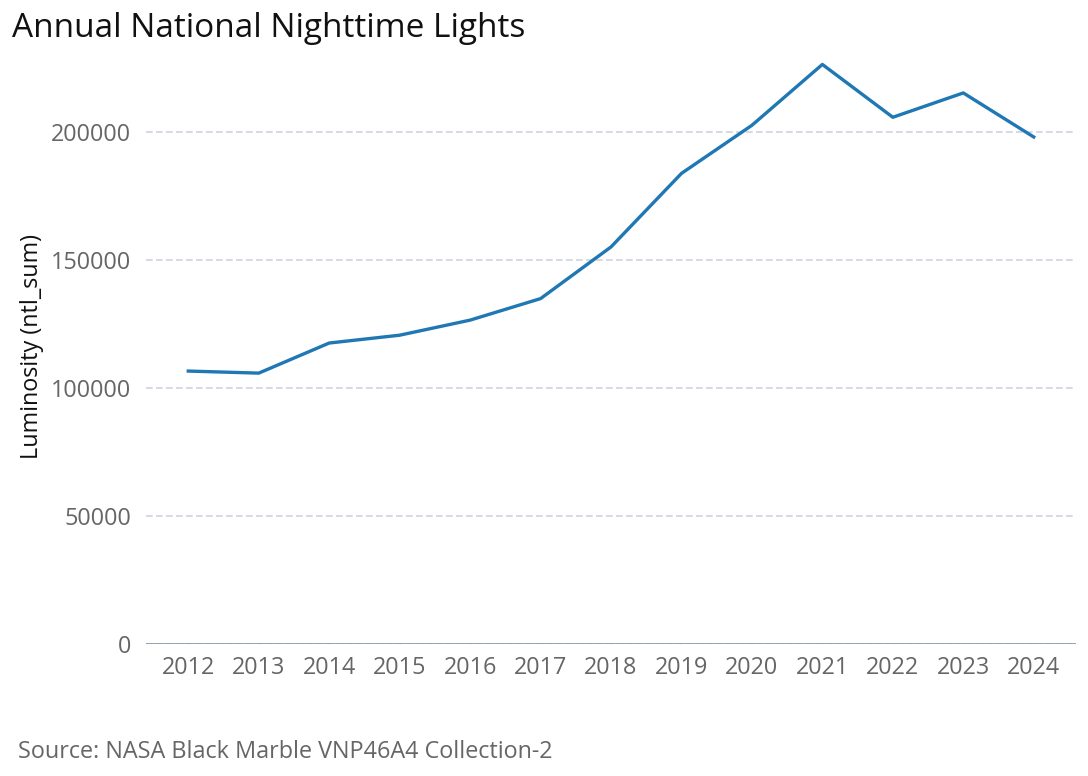

In [150]:
import visuals

visuals.plot_line_chart(
    df=ntl_annual_adm0,
    x_col="year",
    value_col="ntl_sum",
    title="Annual National Nighttime Lights",
    source_text="Source: NASA Black Marble VNP46A4 Collection-2",
    xlabel="Year",
    ylabel="Luminosity (ntl_sum)",
    date_col="date",
    marker=None,
)

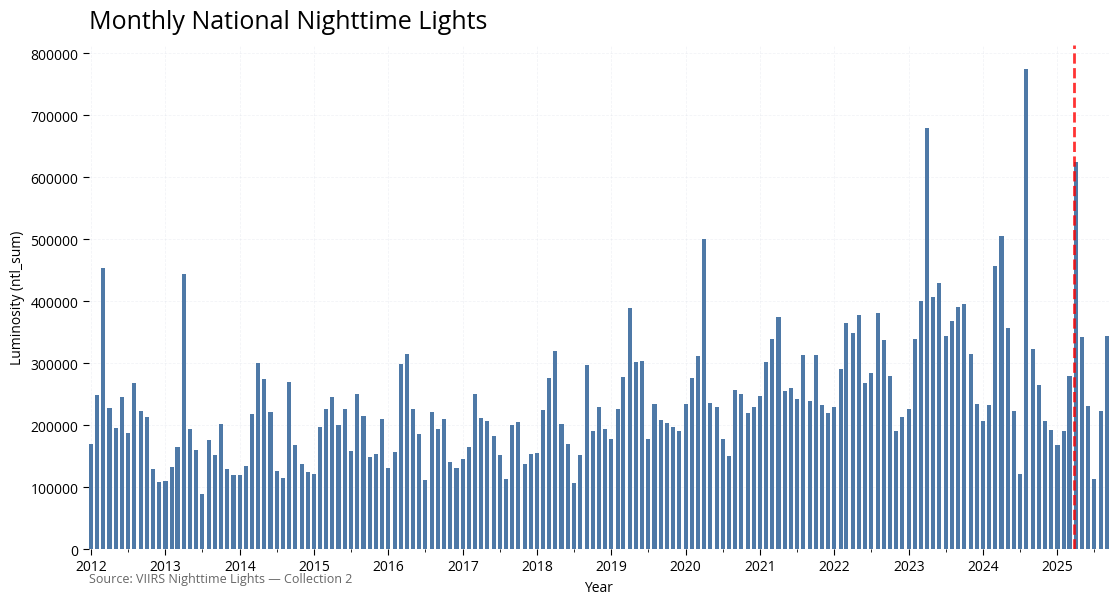

In [151]:
fig, ax = plot_bar_chart(
    df=ntl_monthly_adm0,
    x_col="date",
    value_col="ntl_sum",
    title="Monthly National Nighttime Lights",
    xlabel="Year",
    ylabel="Luminosity (ntl_sum)",
    earthquake_marker="2025-03-25",
    date_col="date",
    bar_width=20,
)

In [152]:
# Quick usage examples (optional)
# Set your desired baseline year or range here
user_baseline_year = 2022
# Optionally set a specific current year (None -> uses max available year)
user_current_year = 2024

# Annual baseline vs current percentage change (single baseline year)

# Prefer a date column if available to derive year
date_cand_ann = "date" if "date" in ntl_annual_adm0.columns else None

# Annual baseline vs current percentage change (baseline range mean)
annual_pct_range = annual_ntl_pct_change(
    ntl_annual_adm0,
    year_col="year",
    value_col="ntl_sum",
    date_col=date_cand_ann,
    baseline_year=user_baseline_year,
    current_year=user_current_year,
    mode="baseline",
)

# Annual YoY per-year changes
annual_yoy = annual_ntl_pct_change(
    ntl_annual_adm0,
    year_col="year",
    value_col="ntl_sum",
    date_col=date_cand_ann,
    mode="yoy",
)

user_baseline_year = 2024
user_current_year = 2025

monthly_ntl_baseline = monthly_ntl_yoy(
    ntl_monthly_adm0,
    date_col="date",
    value_col="ntl_sum",
    baseline_year=user_baseline_year,
)

monthly_yoy = monthly_ntl_yoy(
    ntl_monthly_adm0,
    date_col="date",
    value_col="ntl_sum",
    baseline_year=user_baseline_year,
)

monthly_yoy_industrial = monthly_ntl_yoy(
    ntl_monthly_adm0,
    date_col="date",
    value_col="ntl_ind_5km_sum",
    baseline_year=user_baseline_year,
)

monthly_yoy_nonindustrial = monthly_ntl_yoy(
    ntl_monthly_adm0,
    date_col="date",
    value_col="ntl_noind_5km_sum",
    baseline_year=user_baseline_year,
)

In [168]:
ntl_monthly_adm0["date"] = pd.to_datetime(ntl_monthly_adm0["date"])
ntl_monthly_adm0["year_col"] = ntl_monthly_adm0["date"].dt.year
ntl_monthly_adm0["month"] = ntl_monthly_adm0["date"].dt.month

ntl_corrected = ntl_monthly_adm0[ntl_monthly_adm0["month"] <= 9]
ntl_corrected = (
    ntl_corrected.groupby([pd.Grouper(key="date", freq="YS"), "year_col"])[["ntl_sum", 'ntl_ind_5km_sum', 'ntl_noind_5km_sum']]
    .sum()
    .reset_index()
)

annual_yoy_9months = annual_ntl_pct_change(
    ntl_corrected, year_col="year", value_col="ntl_sum", date_col="date", mode="yoy"
)

In [154]:
annual_yoy = annual_yoy.merge(annual_yoy_9months, on=["year"], how="right")
annual_yoy.rename(
    columns={
        "ntl_sum_x": "ntl_sum",
        "pct_change_x": "pct_change_full_year",
        "pct_change_y": "pct_change_9months",
    },
    inplace=True,
)

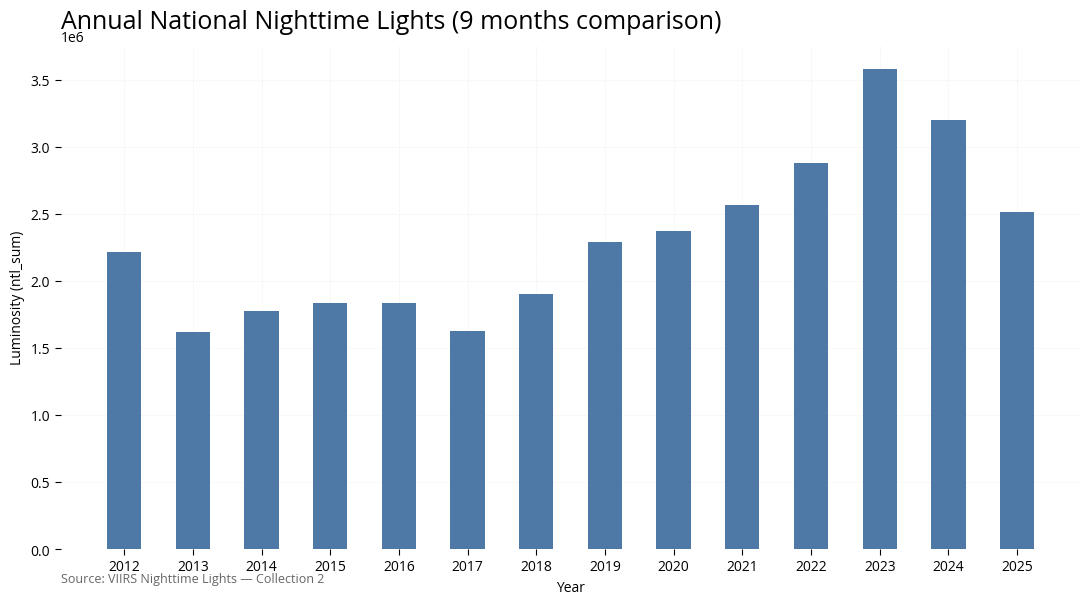

In [163]:
fig, ax = plot_bar_chart(
    df=annual_yoy,
    x_col="year",
    value_col="ntl_sum_y",
    title="Annual National Nighttime Lights (9 months comparison)",
    xlabel="Year",
    ylabel="Luminosity (ntl_sum)",
    #earthquake_marker="2025-03-25",
    date_col="date",
    bar_width=0.5,
)

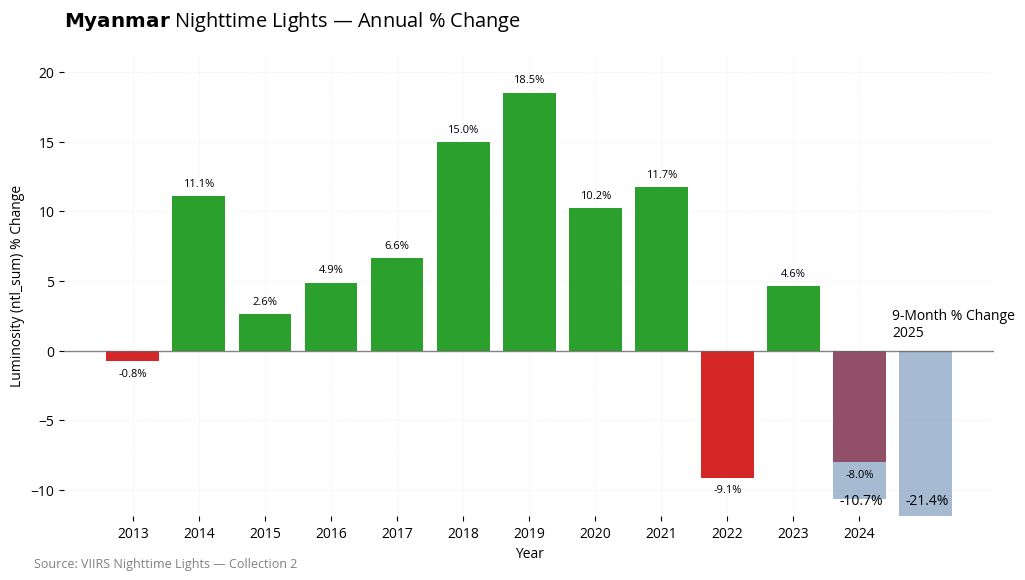

In [13]:
fig, ax = plot_bar_chart(
    df=annual_yoy,
    x_col="year",  # Use year column directly instead of date
    value_col="pct_change_full_year",
    title="Myanmar Nighttime Lights — Annual % Change",
    xlabel="Year",
    ylabel="Luminosity (ntl_sum) % Change",
    earthquake_marker="2025-03-25",
    date_col=None,  # No date column needed
    bar_width=0.8,  # Use relative width instead of absolute
    is_percentage=True,
)

df = annual_yoy[annual_yoy["year"] >= 2024]
change_2025 = df[df["year"] == 2025]["pct_change_9months"].values[0]
change_2024 = df[df["year"] == 2024]["pct_change_9months"].values[0]
ax.bar(
    df["year"],
    df["pct_change_9months"],
    width=0.8,
    color="#4e79a78a",
    label="Annual % Change",
    alpha=0.5,
)
ax.text(2024.5, 1, "9-Month % Change\n2025", color="black", fontsize=10)
ax.text(2024.7, -11, f"{change_2025:.1f}%", color="black", fontsize=10)
ax.text(2023.7, -11, f"{change_2024:.1f}%", color="black", fontsize=10)

# Add y-label for 2025 bar
# ax.text(2025, change_2025 + 0.5, f'{change_2025:.1f}%', ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')

plt.show()
# annual_yoy[annual_yoy['year']>=2024].plot(x='year', y=['pct_change_9months'], ax=ax)

In [14]:
ntl_monthly_adm0["date"] = pd.to_datetime(ntl_monthly_adm0["date"])
ntl_monthly_adm0["year_col"] = ntl_monthly_adm0["date"].dt.year
ntl_comparison = ntl_monthly_adm0[ntl_monthly_adm0["year_col"].isin([2024, 2025])]
ntl_comparison["year_col"] = ntl_comparison["year_col"].astype(str)
ntl_comparison["month"] = ntl_comparison["date"].dt.month

/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_26758/3380796522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntl_comparison["year_col"] = ntl_comparison["year_col"].astype(str)
/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_26758/3380796522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntl_comparison["month"] = ntl_comparison["date"].dt.month


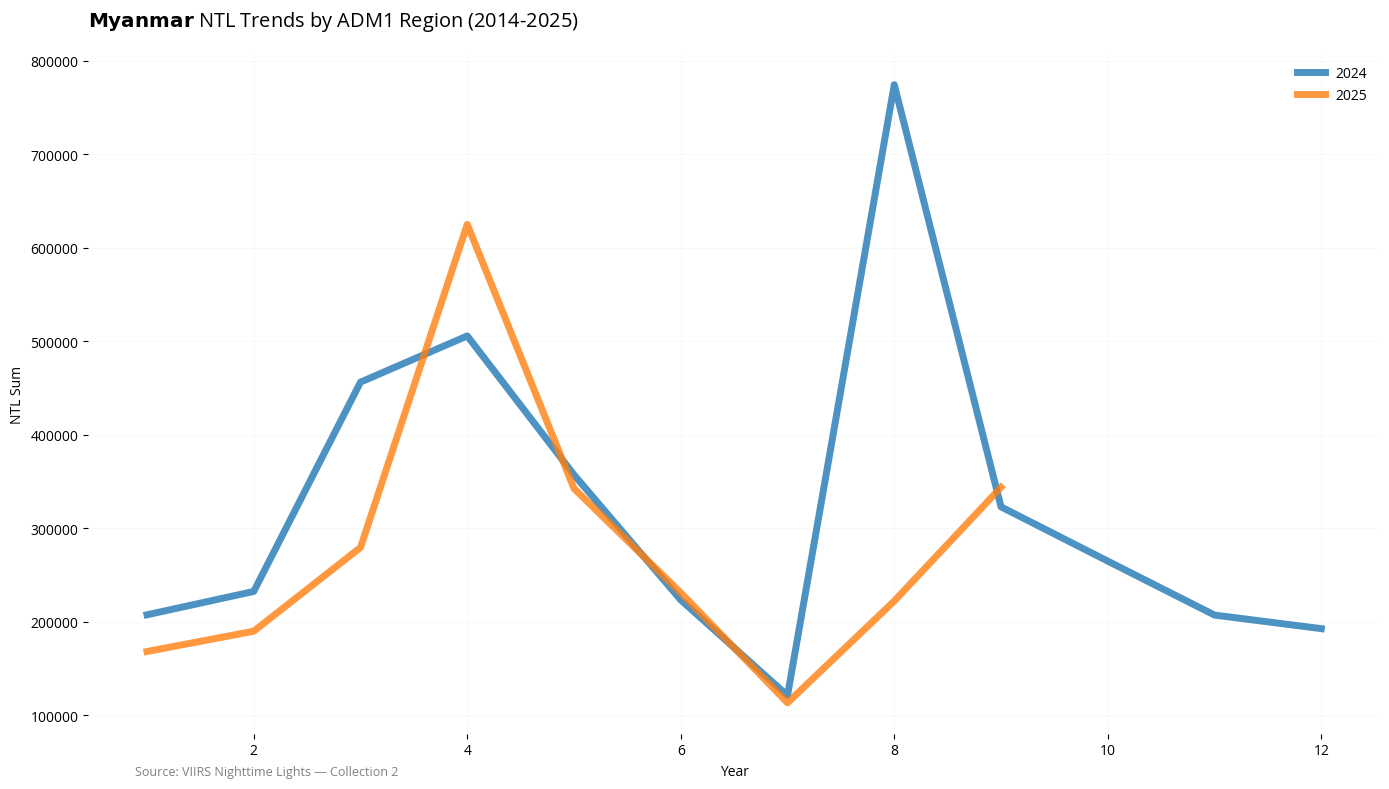

In [15]:
plot_comparative_lines(
    df=ntl_comparison,
    x_col="month",
    value_col="ntl_sum",
    group_col="year_col",
    title="Myanmar NTL Trends by ADM1 Region (2014-2025)",
    xlabel="Year",
    ylabel="NTL Sum",
    date_col="date",
    figsize=(14, 8),
    linewidth=5,
    marker_size=0,
)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': '$\\mathbf{Change}$ in Monthly Nightlights from 2024 to 2025'}, xlabel='Year', ylabel='Luminosity (ntl_sum) % Change'>)

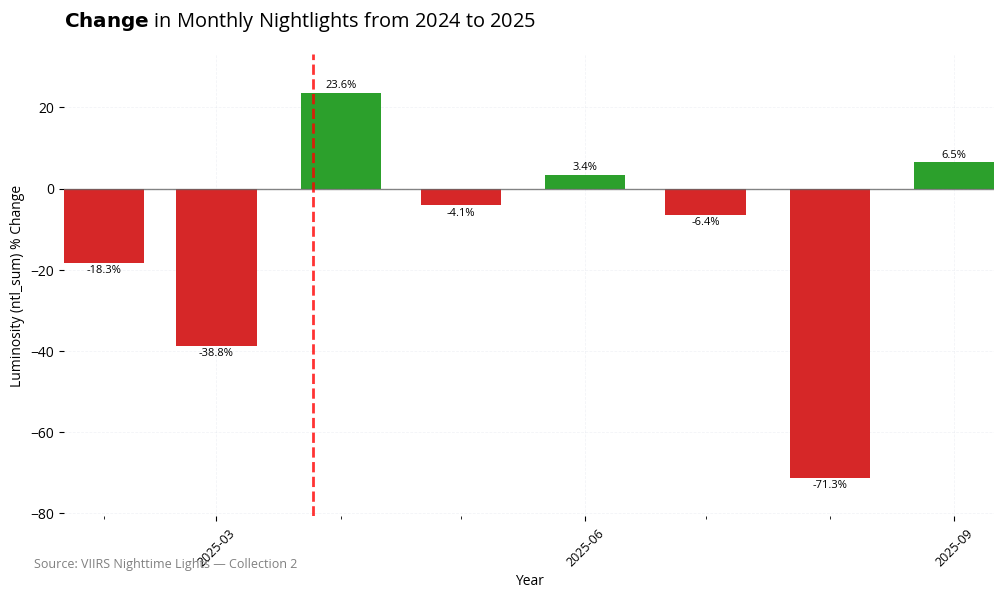

In [16]:
plot_bar_chart(
    df=monthly_yoy[monthly_yoy["date"] > "2025-01-01"],
    x_col="date",  # Use year column directly instead of date
    value_col="pct_change",
    title="Change in Monthly Nightlights from 2024 to 2025",
    xlabel="Year",
    ylabel="Luminosity (ntl_sum) % Change",
    earthquake_marker="2025-03-25",
    date_col=None,  # No date column needed
    bar_width=20,  # Use relative width instead of absolute
    is_percentage=True,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


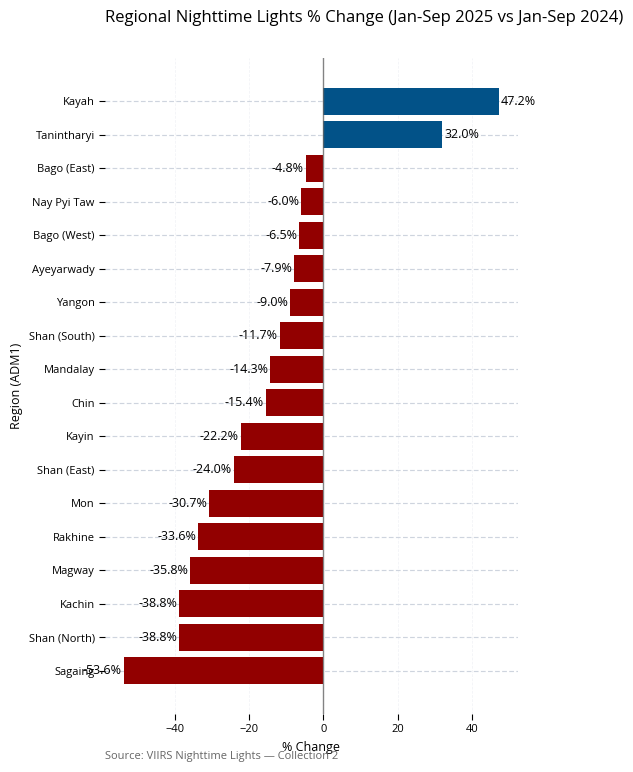

In [139]:
%load_ext autoreload
%autoreload 2  
# sys.path.append('../../../src/')
from visuals import *

# Create regional comparison bar chart
plot_regional_ntl_change(
    ntl_monthly_adm1,
    year1=2024,
    year2=2025,
    max_month=9,
    title="Regional Nighttime Lights % Change (Jan-Sep 2025 vs Jan-Sep 2024)",
    figsize = (5, 8)
)

In [283]:
earthquake_impact = pd.read_excel(
    "../../../data/MMR_EQ_GRADE_damage_results_Ditte_042325.xlsx"
)
earthquake_impact.dropna(subset="Region", inplace=True)
earthquake_impact.shape
earthquake_impact.sort_values(by="TOTAL_DMG", inplace=True, ascending=False)
most_impacted_regions = earthquake_impact["State/Region Pcode"].head(6)
least_impacted_regions = earthquake_impact["State/Region Pcode"].tail(4)
moderately_impacted_regions = earthquake_impact["State/Region Pcode"].iloc[6:11]

In [284]:
most_impacted_regions = ntl_annual_adm1[
    (ntl_annual_adm1["ADM1_PCODE"].isin(most_impacted_regions))
    | (ntl_annual_adm1["ADM1_ALTPC"].isin(most_impacted_regions))
]["ADM1_EN"].unique()
least_impacted_regions = ntl_annual_adm1[
    (ntl_annual_adm1["ADM1_PCODE"].isin(least_impacted_regions))
    | (ntl_annual_adm1["ADM1_ALTPC"].isin(least_impacted_regions))
]["ADM1_EN"].unique()
moderately_impacted_regions = ntl_annual_adm1[
    (ntl_annual_adm1["ADM1_PCODE"].isin(moderately_impacted_regions))
    | (ntl_annual_adm1["ADM1_ALTPC"].isin(moderately_impacted_regions))
]["ADM1_EN"].unique()

## Trends in Earthquake Impacted Regions


In [285]:
ntl_monthly_adm1["date"] = pd.to_datetime(ntl_monthly_adm1["date"])
ntl_monthly_adm1["year_col"] = ntl_monthly_adm1["date"].dt.year
ntl_monthly_adm1["month"] = ntl_monthly_adm1["date"].dt.month

# Filter for 2024-2025 comparison and top 6 regions
# top_regions = ntl_monthly_adm1[ntl_monthly_adm1['ADM1_EN'].isin(most_impacted_regions+least_impacted_regions)]['ADM1_EN'].unique()
ntl_regional_comparison = ntl_monthly_adm1[
    # (ntl_monthly_adm1['ADM1_EN'].isin(top_regions)) &
    (ntl_monthly_adm1["year_col"].isin([2024, 2025]))
].copy()

ntl_regional_comparison["year_col"] = ntl_regional_comparison["year_col"].astype(str)

In [286]:
ntl_regional_comparison["earthquake_impact"] = ntl_regional_comparison["ADM1_EN"].apply(
    lambda x: "Most Impacted"
    if x in most_impacted_regions
    else ("Least Impacted" if x in least_impacted_regions else "Moderately Impacted")
)

ntl_earthquake_comparison = (
    ntl_regional_comparison.groupby(["earthquake_impact", "year_col", "month", "date"])[
        "ntl_sum"
    ]
    .sum()
    .reset_index()
)

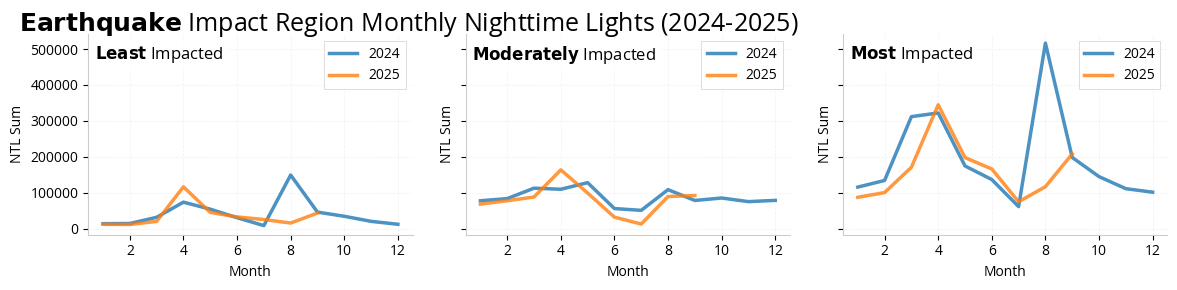

In [287]:
plot_comparative_lines_subplots(
    df=ntl_earthquake_comparison,
    category_col="earthquake_impact",  # Create subplots for each region
    x_col="month",  # X-axis: month
    value_col="ntl_sum",  # Y-axis: NTL sum
    group_col="year_col",  # Different lines for different years (2024 vs 2025)
    title="Earthquake Impact Region Monthly Nighttime Lights (2024-2025)",
    xlabel="Month",
    ylabel="NTL Sum",
    date_col="date",
    ncols=3,  # 3 columns of subplots
    figsize_per_subplot=(4, 3),
    linewidth=2.5,
    marker_size=0,
    colors=["#1f77b4", "#ff7f0e"],  # Blue for 2024, Orange for 2025
    share_axes=True
);

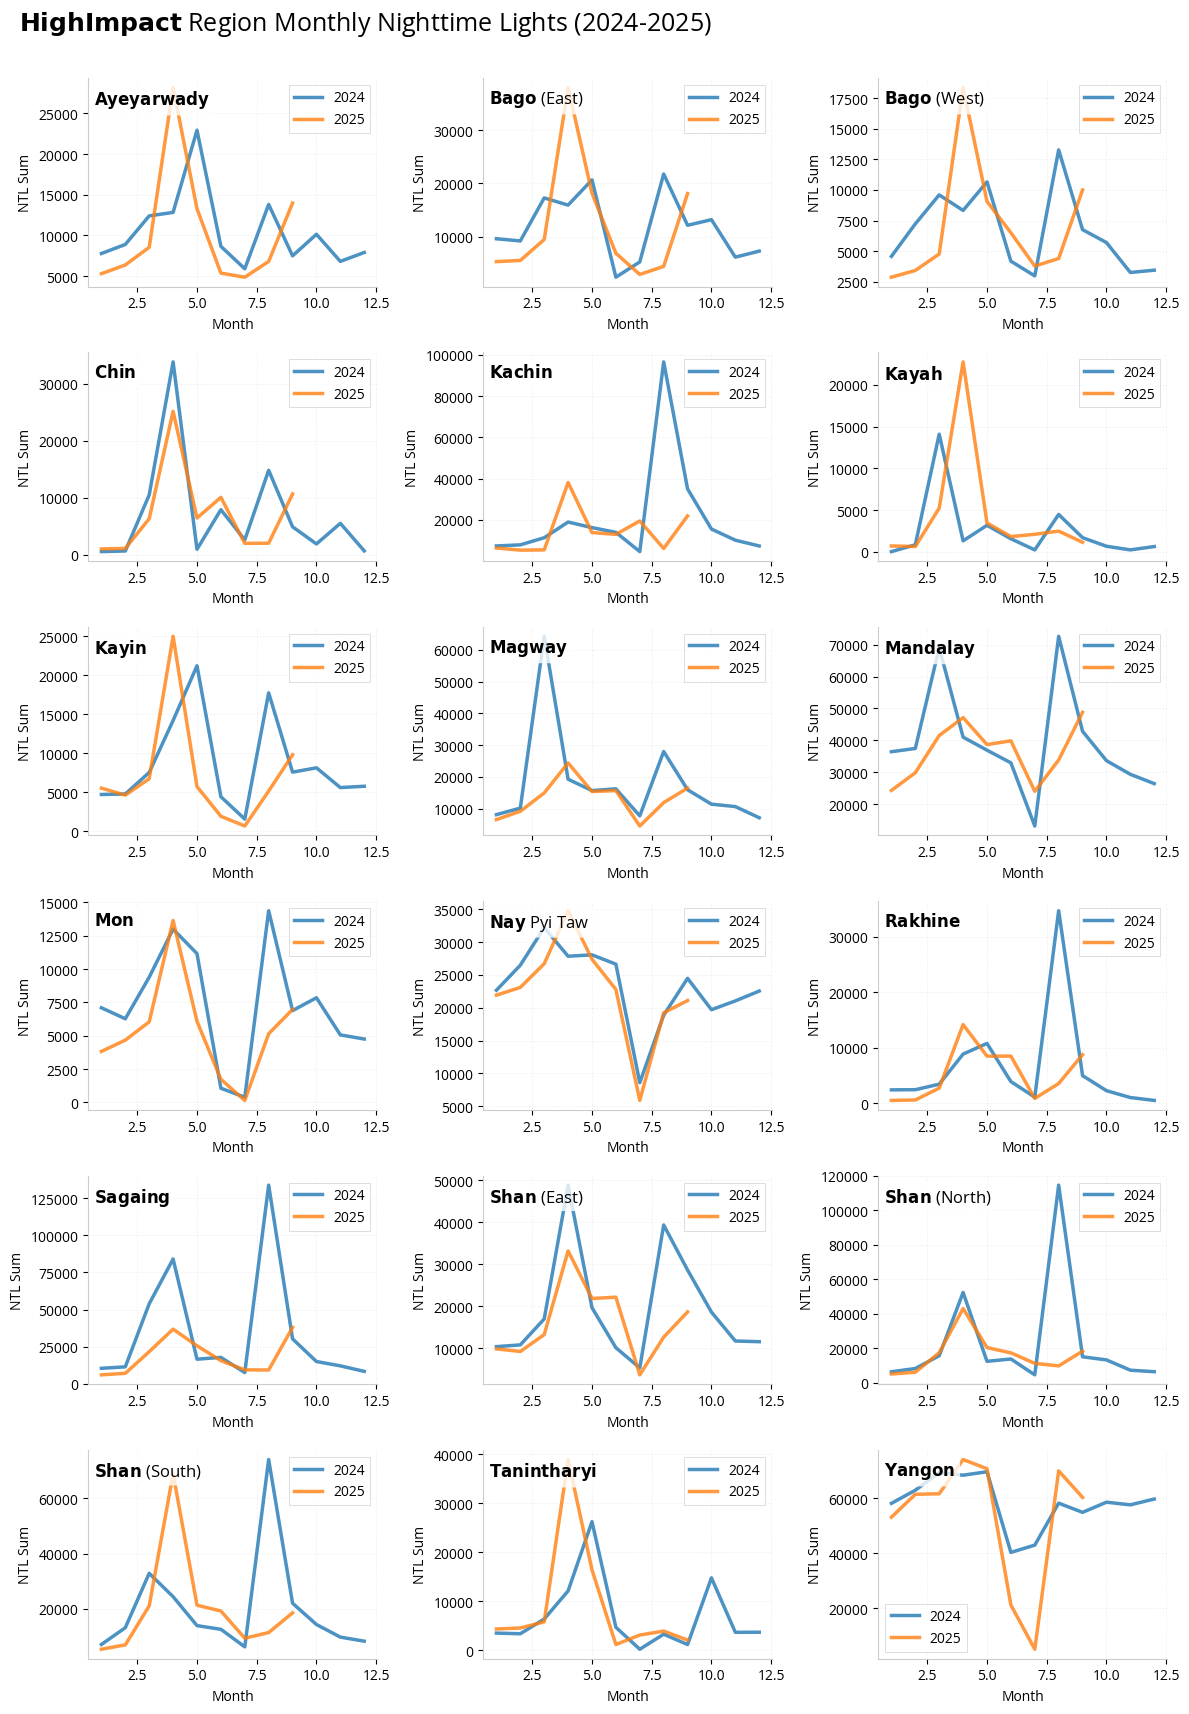

In [288]:
plot_comparative_lines_subplots(
    df=ntl_regional_comparison,
    category_col="ADM1_EN",  # Create subplots for each region
    x_col="month",  # X-axis: month
    value_col="ntl_sum",  # Y-axis: NTL sum
    group_col="year_col",  # Different lines for different years (2024 vs 2025)
    title="HighImpact Region Monthly Nighttime Lights (2024-2025)",
    xlabel="Month",
    ylabel="NTL Sum",
    date_col="date",
    ncols=3,  # 3 columns of subplots
    figsize_per_subplot=(4, 3),
    linewidth=2.5,
    marker_size=0,
    colors=["#1f77b4", "#ff7f0e"],  # Blue for 2024, Orange for 2025
);

- Shan South and Bago East, in the high impact earthquake regions saw an increase in lights after the earthquake

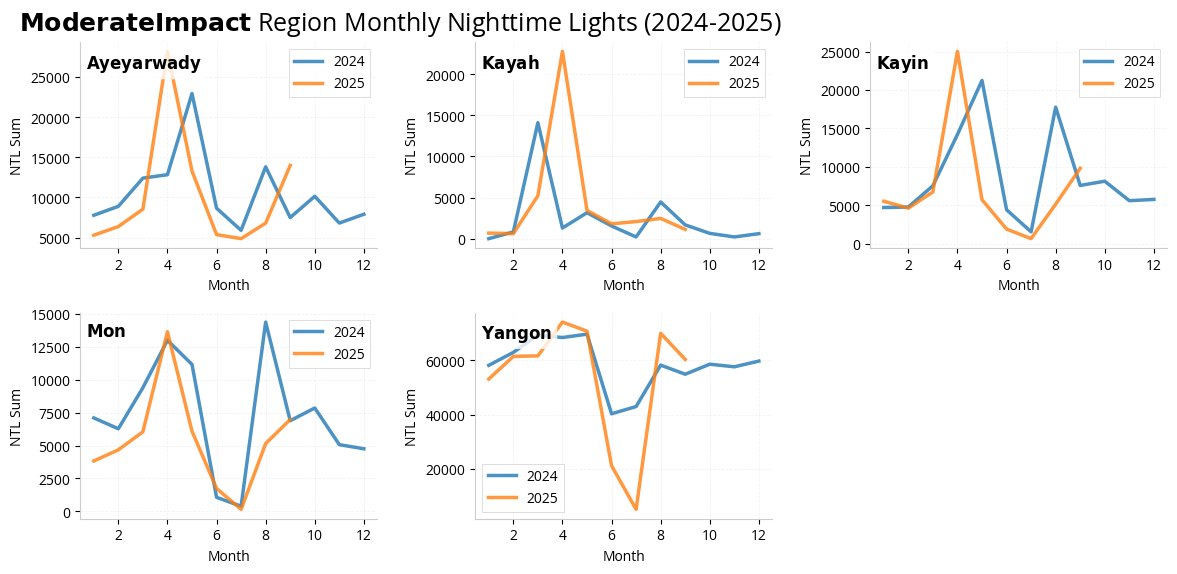

In [289]:
ntl_regional_comparison = ntl_monthly_adm1[
    (ntl_monthly_adm1["ADM1_EN"].isin(moderately_impacted_regions))
    & (ntl_monthly_adm1["year_col"].isin([2024, 2025]))
].copy()

ntl_regional_comparison["year_col"] = ntl_regional_comparison["year_col"].astype(str)

plot_comparative_lines_subplots(
    df=ntl_regional_comparison,
    category_col="ADM1_EN",  # Create subplots for each region
    x_col="month",  # X-axis: month
    value_col="ntl_sum",  # Y-axis: NTL sum
    group_col="year_col",  # Different lines for different years (2024 vs 2025)
    title="ModerateImpact Region Monthly Nighttime Lights (2024-2025)",
    xlabel="Month",
    ylabel="NTL Sum",
    date_col="date",
    ncols=3,  # 3 columns of subplots
    figsize_per_subplot=(4, 3),
    linewidth=2.5,
    marker_size=0,
    colors=["#1f77b4", "#ff7f0e"],  # Blue for 2024, Orange for 2025
    # earthquake_marker=3
);

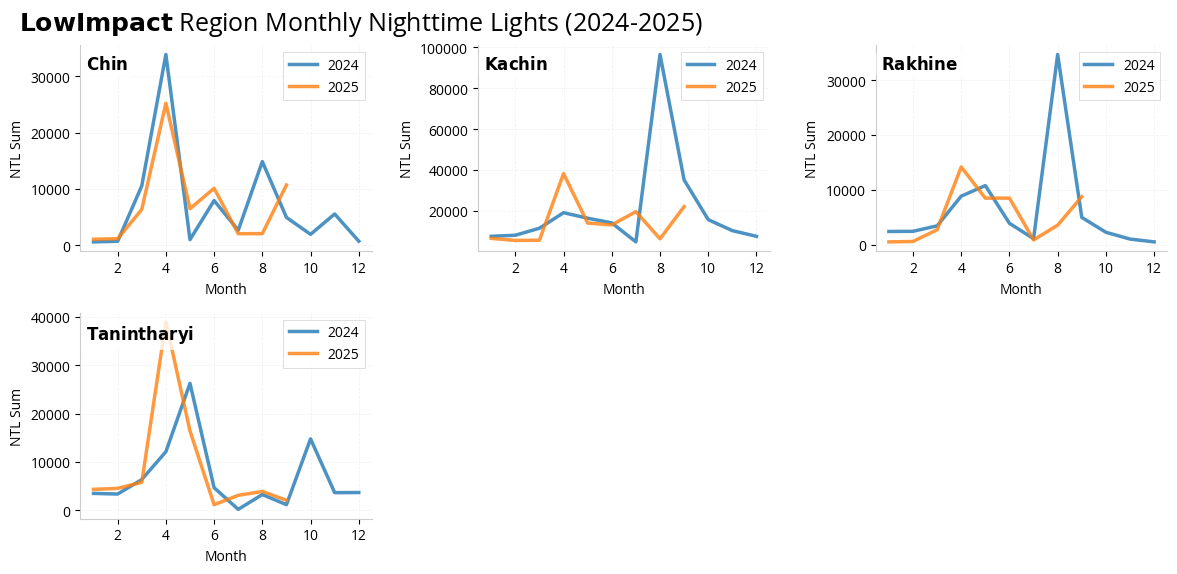

In [290]:
bottom_regions = ntl_annual_adm1[
    ntl_annual_adm1["ADM1_EN"].isin(least_impacted_regions)
]["ADM1_EN"].unique()
ntl_regional_comparison = ntl_monthly_adm1[
    (ntl_monthly_adm1["ADM1_EN"].isin(bottom_regions))
    & (ntl_monthly_adm1["year_col"].isin([2024, 2025]))
].copy()

ntl_regional_comparison["year_col"] = ntl_regional_comparison["year_col"].astype(str)

plot_comparative_lines_subplots(
    df=ntl_regional_comparison,
    category_col="ADM1_EN",  # Create subplots for each region
    x_col="month",  # X-axis: month
    value_col="ntl_sum",  # Y-axis: NTL sum
    group_col="year_col",  # Different lines for different years (2024 vs 2025)
    title="LowImpact Region Monthly Nighttime Lights (2024-2025)",
    xlabel="Month",
    ylabel="NTL Sum",
    date_col="date",
    ncols=3,  # 3 columns of subplots
    figsize_per_subplot=(4, 3),
    linewidth=2.5,
    marker_size=0,
    colors=["#1f77b4", "#ff7f0e"],  # Blue for 2024, Orange for 2025
    # earthquake_marker=3
);

## Nighttime Lights in Industrial Zones

In [291]:
mmr_adm0 = gpd.read_file(
    DATA_FOLDER / "boundaries" / "mmr_polbnda_adm0_250k_mimu_20240215.shp"
)
mmr_adm1 = gpd.read_file(
    DATA_FOLDER / "boundaries" / "mmr_polbnda_adm1_250k_mimu_20240215.shp"
)
mmr_adm2 = gpd.read_file(
    DATA_FOLDER / "boundaries" / "mmr_polbnda_adm2_250k_mimu_20240215.shp"
)
mmr_adm3 = gpd.read_file(
    DATA_FOLDER / "boundaries" / "mmr_polbnda_adm3_250k_mimu_20240215.shp"
)
mmr_adm4 = gpd.read_file(
    DATA_FOLDER / "boundaries" / "mmr_polbnda_adm4_250k_mimu_20240215.shp"
)

In [337]:
industrial_zones = gpd.read_file(
    "../../../data/boundaries/industrial__special_economic_zones_sept2019.shp"
)
industrial_zones = industrial_zones.sjoin(
    mmr_adm3[
        [
            "ADM1_PCODE",
            "ADM1_EN",
            "ADM2_EN",
            "ADM2_PCODE",
            "ADM3_EN",
            "ADM3_PCODE",
            "geometry",
        ]
    ]
)

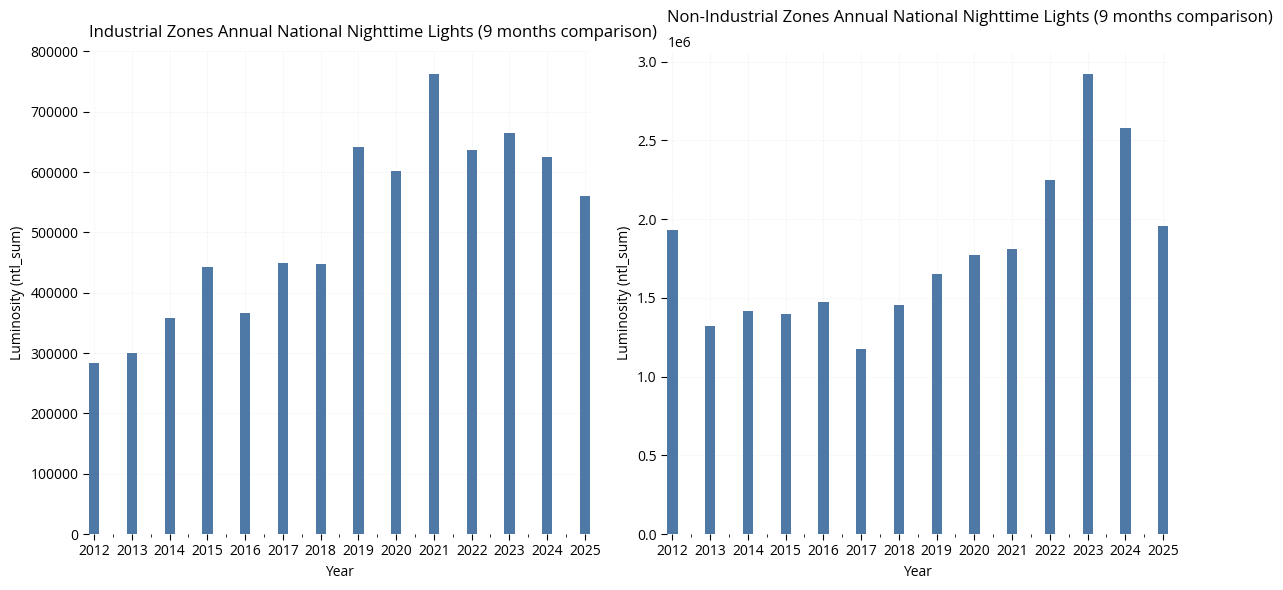

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot
fig, axes[0] = plot_bar_chart(
    df=ntl_corrected,
    x_col="date",
    value_col="ntl_ind_5km_sum",
    title="Industrial Zones Annual National Nighttime Lights (9 months comparison)",
    xlabel="Year",
    ylabel="Luminosity (ntl_sum)",
    #earthquake_marker="2025-03-25",
    date_col="date",
    bar_width=100,
    ax=axes[0]
)

# Second subplot
fig, axes[1] = plot_bar_chart(
    df=ntl_corrected,
    x_col="date",
    value_col="ntl_noind_5km_sum",
    title="Non-Industrial Zones Annual National Nighttime Lights (9 months comparison)",
    xlabel="Year",
    ylabel="Luminosity (ntl_sum)",
    date_col="date",
    bar_width=100,
    ax=axes[1]
)

plt.tight_layout()
plt.show()

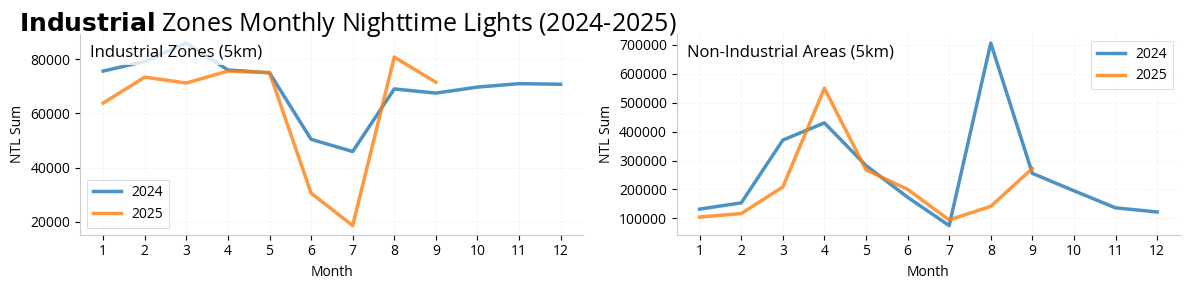

In [63]:
# Melt for 5km buffer

ntl_monthly_adm0["date"] = pd.to_datetime(ntl_monthly_adm0["date"])
ntl_ind_comparison = ntl_monthly_adm0[["date", "ntl_sum", "year_col", "month", "ntl_ind_5km_sum", "ntl_noind_5km_sum", "ntl_ind_10km_sum", "ntl_noind_10km_sum"]]

df1_5km = ntl_ind_comparison[["date", "ntl_ind_5km_sum"]].copy()
df1_5km.rename(columns={"ntl_ind_5km_sum": "ntl_sum"}, inplace=True)
df1_5km["type"] = "Industrial Zones (5km)"

df2_5km = ntl_ind_comparison[["date", "ntl_noind_5km_sum"]].copy()
df2_5km.rename(columns={"ntl_noind_5km_sum": "ntl_sum"}, inplace=True)
df2_5km["type"] = "Non-Industrial Areas (5km)"

ntl_ind_comparison_melted_5km = pd.concat([df1_5km, df2_5km], ignore_index=True)
ntl_ind_comparison_melted_5km["year_col"] = ntl_ind_comparison_melted_5km["date"].dt.year
ntl_ind_comparison_melted_5km["month"] = ntl_ind_comparison_melted_5km["date"].dt.month


plot_comparative_lines_subplots(
    df=ntl_ind_comparison_melted_5km[
        ntl_ind_comparison_melted_5km["year_col"].isin([2024, 2025])
    ],
    category_col="type",  # Create subplots for each region
    x_col="month",  # X-axis: month
    value_col="ntl_sum",  # Y-axis: NTL sum
    group_col="year_col",  # Different lines for different years (2024 vs 2025)
    title="Industrial Zones Monthly Nighttime Lights (2024-2025)",
    xlabel="Month",
    ylabel="NTL Sum",
    date_col="date",
    ncols=2,  # 3 columns of subplots
    figsize_per_subplot=(6, 3),
    linewidth=2.5,
    marker_size=0,
    colors=["#1f77b4", "#ff7f0e"],  # Blue for 2024, Orange for 2025
    share_axes=False
);

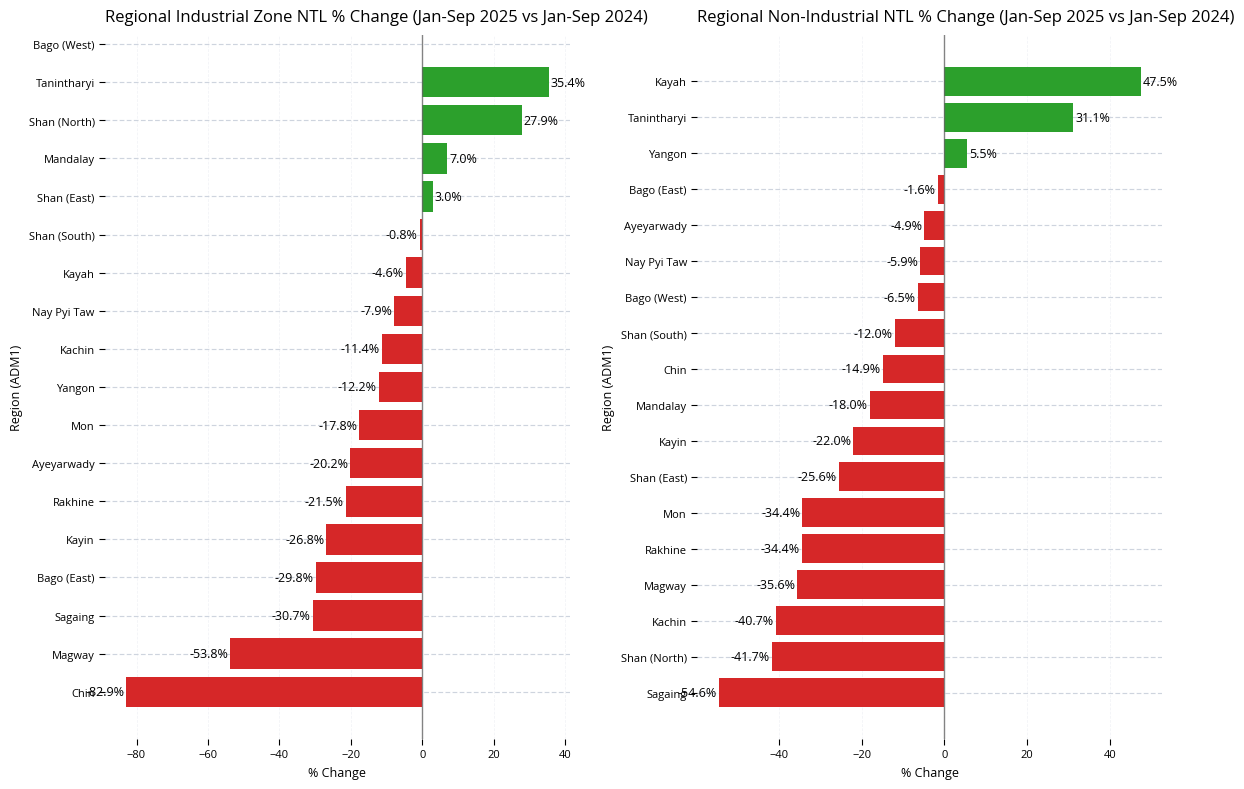

In [67]:
# Create side-by-side comparison of industrial vs non-industrial zones
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Use industrial zone nighttime lights
plot_regional_ntl_change(
    ntl_monthly_adm1,
    year1=2024,
    year2=2025,
    max_month=9,
    value_col="ntl_ind_5km_sum",
    title="Regional Industrial Zone NTL % Change (Jan-Sep 2025 vs Jan-Sep 2024)",
    figsize=(5, 8),
    ax=axes[0]
)

# Use non-industrial nighttime lights
plot_regional_ntl_change(
    ntl_monthly_adm1,
    year1=2024,
    year2=2025,
    max_month=9,
    value_col="ntl_noind_5km_sum",
    title="Regional Non-Industrial NTL % Change (Jan-Sep 2025 vs Jan-Sep 2024)",
    figsize=(5, 8),
    ax=axes[1]
)

plt.tight_layout()
plt.show()

/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_15061/671949646.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ADM1_EN"] = pd.Categorical(


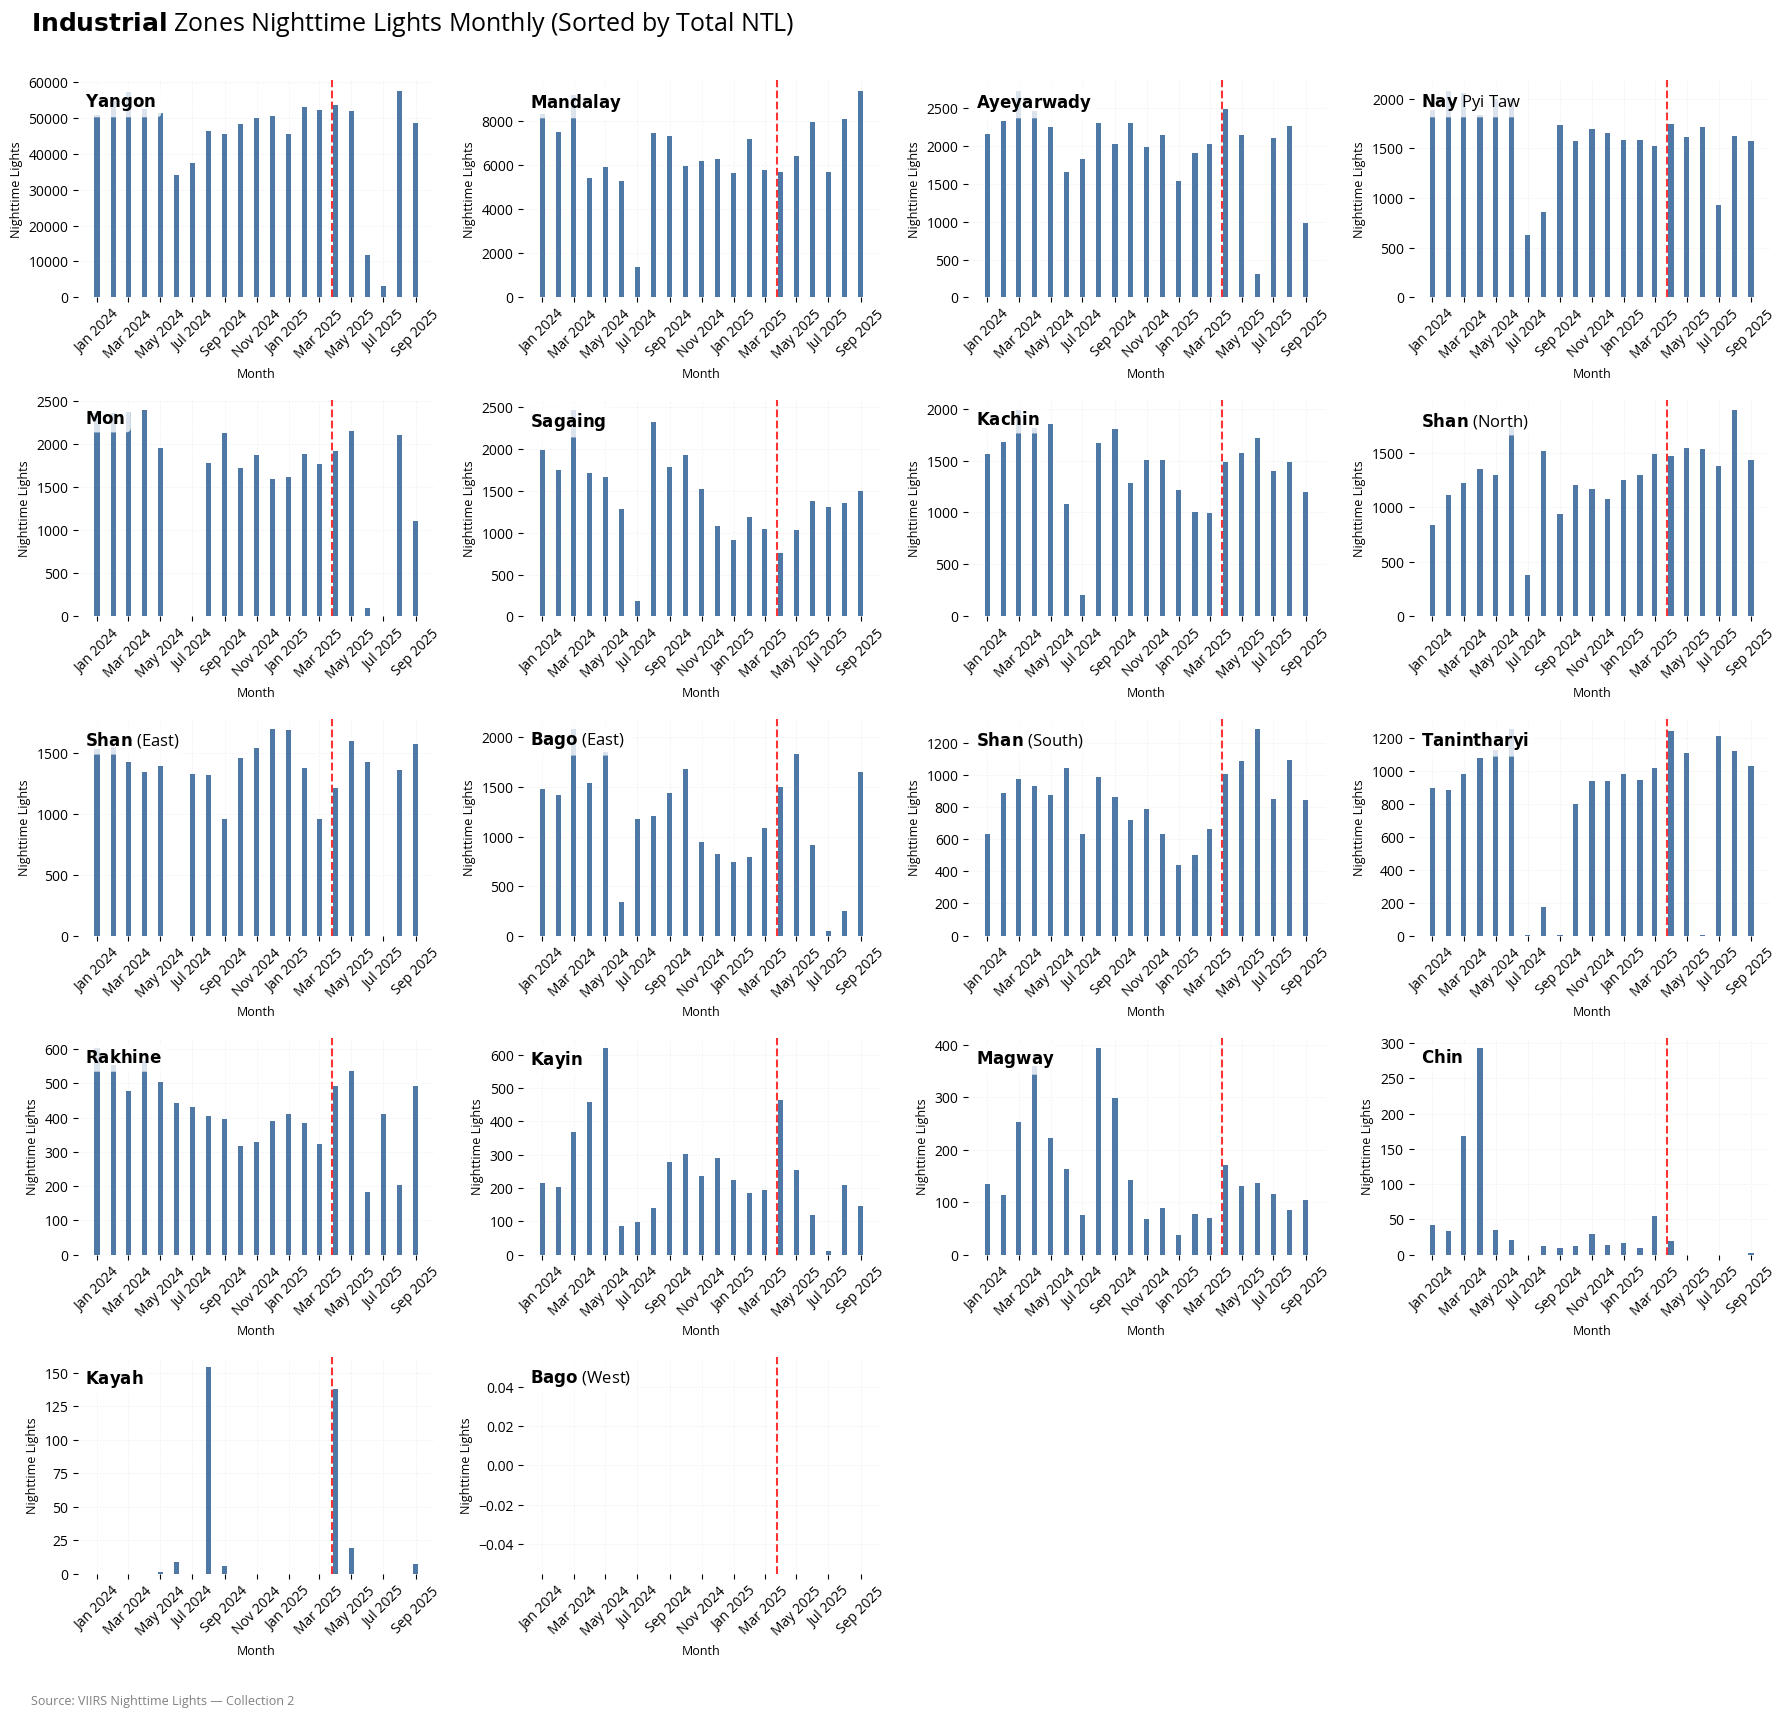

In [331]:
df = ntl_monthly_adm1#[ntl_monthly_adm1_ind_10km["ADM1_EN"].isin(admin1_industrial)]
df = df[df["date"] >= "2024-01-01"]

# Sort the dataframe by the same order as the grouped totals
region_totals = (
    df.groupby(["ADM1_PCODE", "ADM1_EN"])["ntl_ind_5km_sum"]
    .sum()
    .reset_index()
    .sort_values(by="ntl_ind_5km_sum", ascending=False)
)
region_order_list = region_totals["ADM1_EN"].tolist()


# Convert ADM1_EN to categorical with the sorted order for proper plotting order
df["ADM1_EN"] = pd.Categorical(
    df["ADM1_EN"], categories=region_order_list, ordered=True
)
df = df.sort_values(["ADM1_EN", "date"])
df['ntl_ind_5km_sum'] = df['ntl_ind_5km_sum'].astype(int)

plot_subplots_bar_charts(
    df,  # Use the sorted dataframe
    x_col="date",
    value_col="ntl_ind_5km_sum",
    group_col="ADM1_EN",
    title="Industrial Zones Nighttime Lights Monthly (Sorted by Total NTL)",
    xlabel="Month",
    ylabel="Nighttime Lights",
    share_axes=False,  # Changed to False so each region has its own y-axis scale
    bar_width=10,
    earthquake_marker="2025-03-25",  # Add earthquake marker
)

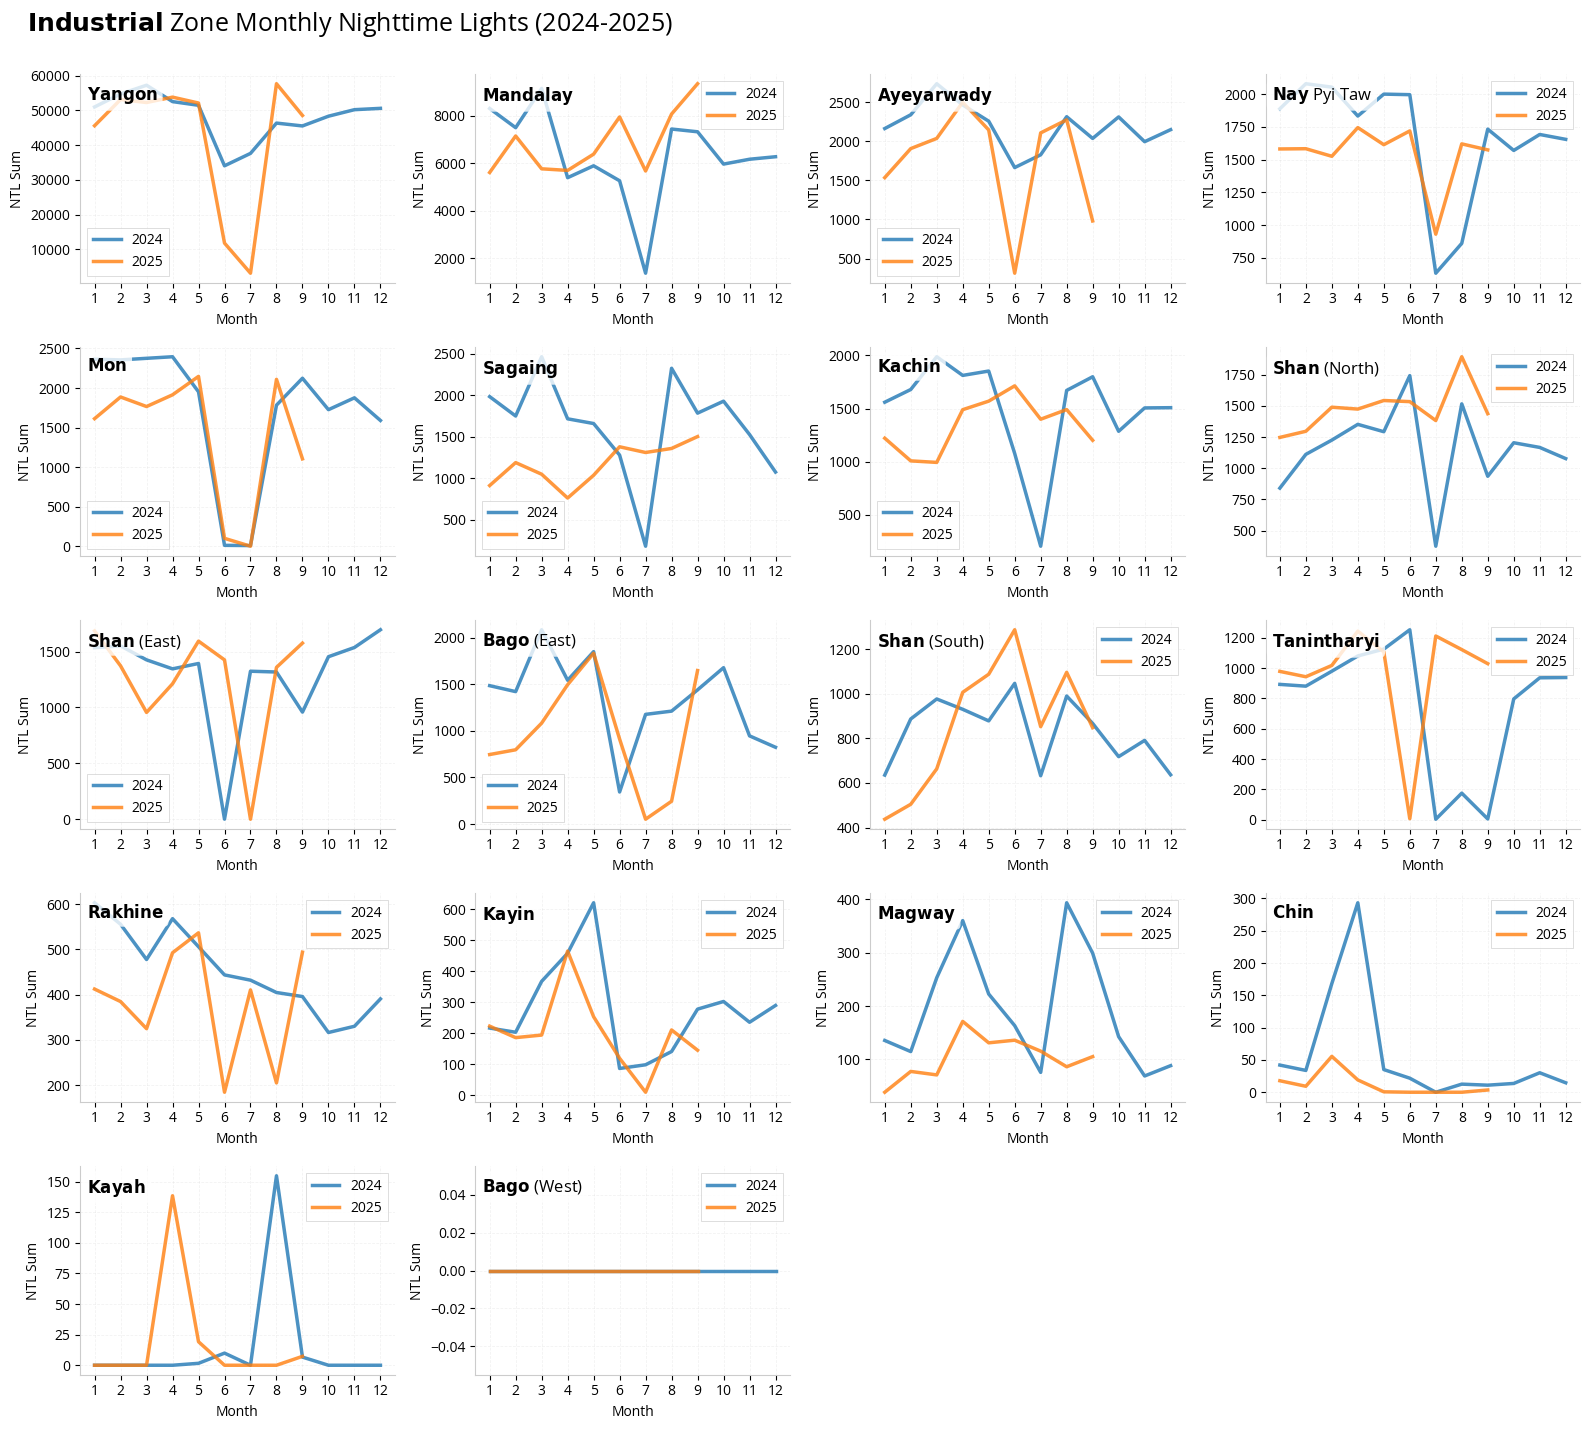

In [332]:


# Filter for 2024-2025 comparison and top 6 regions

ntl_regional_comparison = ntl_monthly_adm1[
    # (ntl_monthly_adm1_ind_10km['ADM1_EN'].isin(top_regions)) &
    (ntl_monthly_adm1["year_col"].isin([2024, 2025]))
].copy()

ntl_regional_comparison["year_col"] = ntl_regional_comparison["year_col"].astype(str)

ntl_regional_comparison["ADM1_EN"] = pd.Categorical(
    ntl_regional_comparison["ADM1_EN"], categories=region_order_list, ordered=True
)
ntl_regional_comparison = ntl_regional_comparison.sort_values(["ADM1_EN", "date"])

plot_comparative_lines_subplots(
    df=ntl_regional_comparison,
    category_col="ADM1_EN",  # Create subplots for each region
    x_col="month",  # X-axis: month
    value_col="ntl_ind_5km_sum",  # Y-axis: NTL sum
    group_col="year_col",  # Different lines for different years (2024 vs 2025)
    title="Industrial Zone Monthly Nighttime Lights (2024-2025)",
    xlabel="Month",
    ylabel="NTL Sum",
    date_col="date",
    ncols=4,  # 3 columns of subplots
    figsize_per_subplot=(4, 3),
    linewidth=2.5,
    marker_size=0,
    colors=["#1f77b4", "#ff7f0e"],  # Blue for 2024, Orange for 2025
    share_axes=False,
    # fig_size=(15, 10)
);

In [341]:
def get_categories(date):
    if pd.Timestamp("2025-03-01") <= date <= pd.Timestamp("2025-04-30"):
        return "Mar-Apr 2025 (Earthquake Period)"
    elif pd.Timestamp("2025-01-01") <= date <= pd.Timestamp("2025-02-28"):
        return "Jan-Feb 2025 (Pre-Earthquake Period)"
    elif pd.Timestamp("2025-05-01") <= date <= pd.Timestamp("2025-06-30"):
        return "May-Jun 2025 (Post-Earthquake Period)"
    elif pd.Timestamp("2025-07-01") <= date <= pd.Timestamp("2025-08-30"):
        return "Jul-Aug 2025 (Recovery Period)"
    else:
        return None  # Return None for dates outside these periods

In [342]:
ntl_monthly_adm1["date"] = pd.to_datetime(ntl_monthly_adm1["date"])
ntl_monthly_adm1["category"] = ntl_monthly_adm1["date"].apply(get_categories)

ntl_earthquake_period = (
    ntl_monthly_adm1.groupby(["ADM1_PCODE", "ADM1_EN", "category"])["ntl_sum"]
    .sum()
    .reset_index()
)

In [343]:
ntl_earthquake_period = mmr_adm1[["ADM1_EN", "ADM1_PCODE", "geometry"]].merge(
    ntl_earthquake_period, on=["ADM1_PCODE", "ADM1_EN"], how="inner"
)

## Spatial Distribution of Nighttime Lights



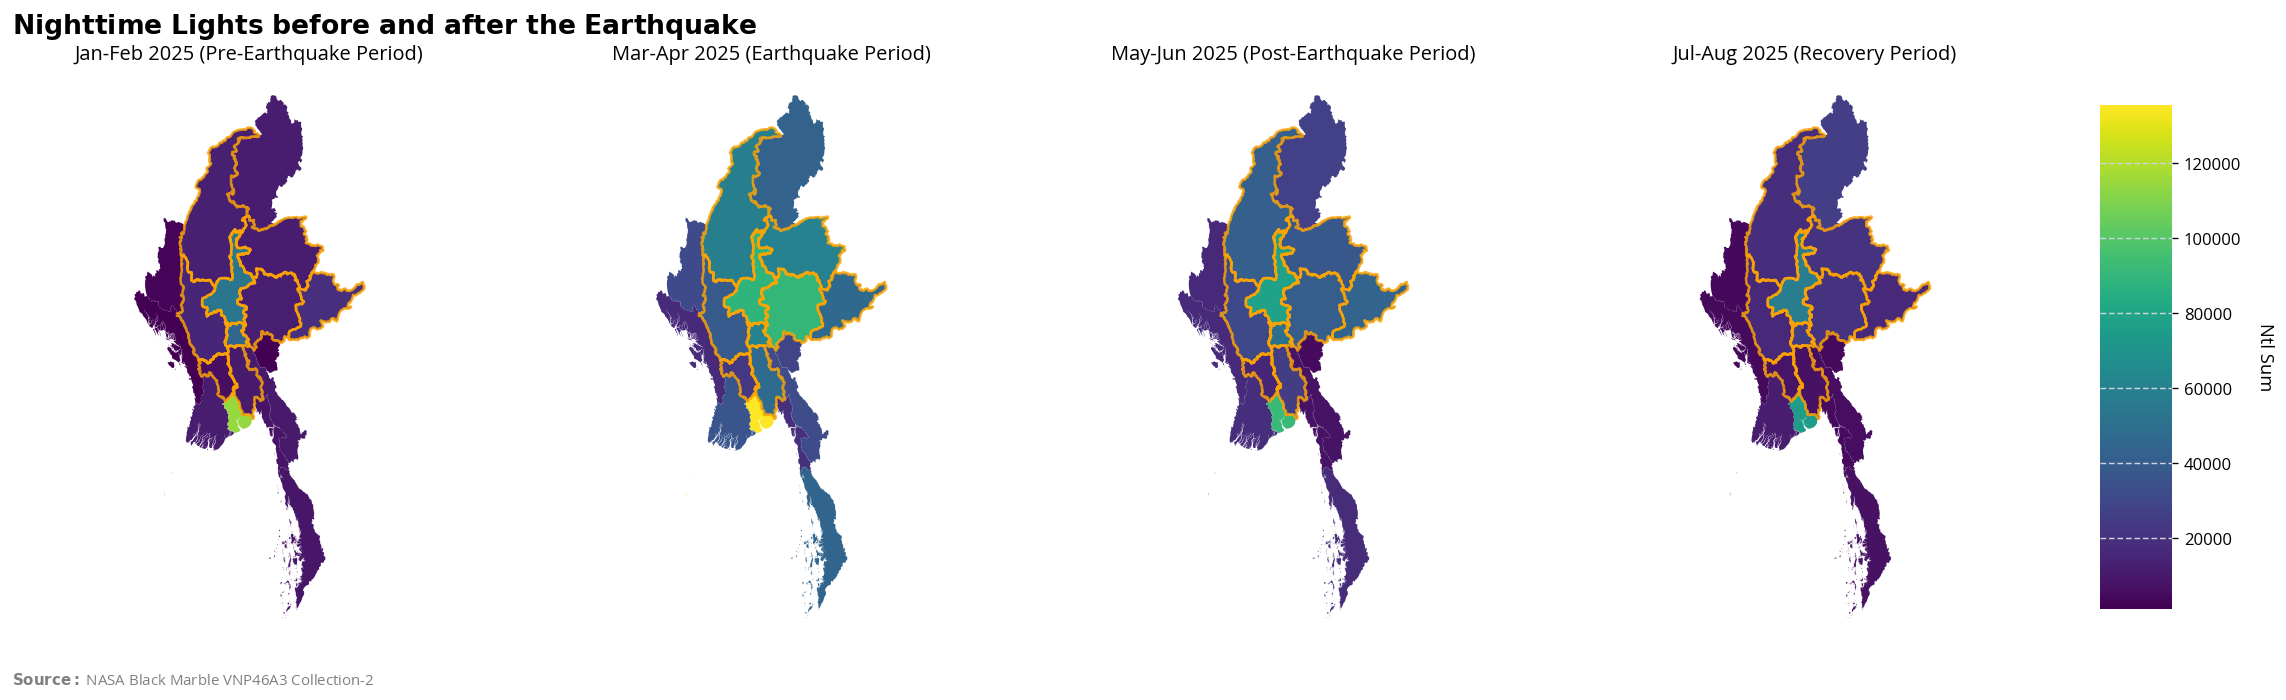

In [344]:
# Sort the earthquake period data by the chronological order of periods
period_order = [
    "Jan-Feb 2025 (Pre-Earthquake Period)",
    "Mar-Apr 2025 (Earthquake Period)",
    "May-Jun 2025 (Post-Earthquake Period)",
    "Jul-Aug 2025 (Recovery Period)",
]

# Filter out any None categories and ensure proper ordering
ntl_earthquake_sorted = ntl_earthquake_period[
    ntl_earthquake_period["category"].notna()
].copy()
ntl_earthquake_sorted["category"] = pd.Categorical(
    ntl_earthquake_sorted["category"], categories=period_order, ordered=True
)
ntl_earthquake_sorted = ntl_earthquake_sorted.sort_values("category")

# Plot maps split by earthquake period categories using the new function
plot_maps_by_category(
    gdf=ntl_earthquake_sorted,
    category_col="category",  # Split by the earthquake period categories
    value_col="ntl_sum",  # Map the NTL sum values
    cmap="viridis",
    figsize=(20, 6),
    ncols=4,
    suptitle="$\\mathbf{Nighttime\\ Lights\\ before\\ and\\ after\\ the\\ Earthquake}$",
    source_text="$\\mathbf{Source:}$ NASA Black Marble VNP46A3 Collection-2",
    legend=True,
    boundary_gdf=mmr_adm1[
        mmr_adm1["ADM1_EN"].isin(most_impacted_regions)
    ],  # Use country boundary instead
    boundary_kwargs={
        "color": "orange",
        "linewidth": 1.5,
        "alpha": 0.8,
    },  # Boundary styling
)

In [345]:
ntl_daily = pd.DataFrame()

for file in glob.glob(str(NTL_FOLDER / "daily/*adm1_daily*.csv")):
    df = pd.read_csv(file)
    ntl_daily = pd.concat([ntl_daily, df], ignore_index=True)

In [346]:
ntl_daily["year_col"] = pd.to_datetime(ntl_daily["date"]).dt.year
ntl_daily["year_col"] = ntl_daily["year_col"].astype(str)

In [347]:
ntl_daily["day"] = pd.to_datetime(ntl_daily["date"]).dt.day
ntl_daily["month"] = pd.to_datetime(ntl_daily["date"]).dt.month
ntl_daily["month_day"] = pd.to_datetime(ntl_daily["date"]).dt.strftime("%m-%d")

In [ ]:
# ntl_daily['date'] = pd.to_datetime(ntl_daily['date'])
# ntl_daily = ntl_daily.groupby([pd.Grouper(key='date', freq='MS'), 'ADM1_EN'])['ntl_sum'].sum().reset_index()

### Percentage Change in Nightlights at Admin 2

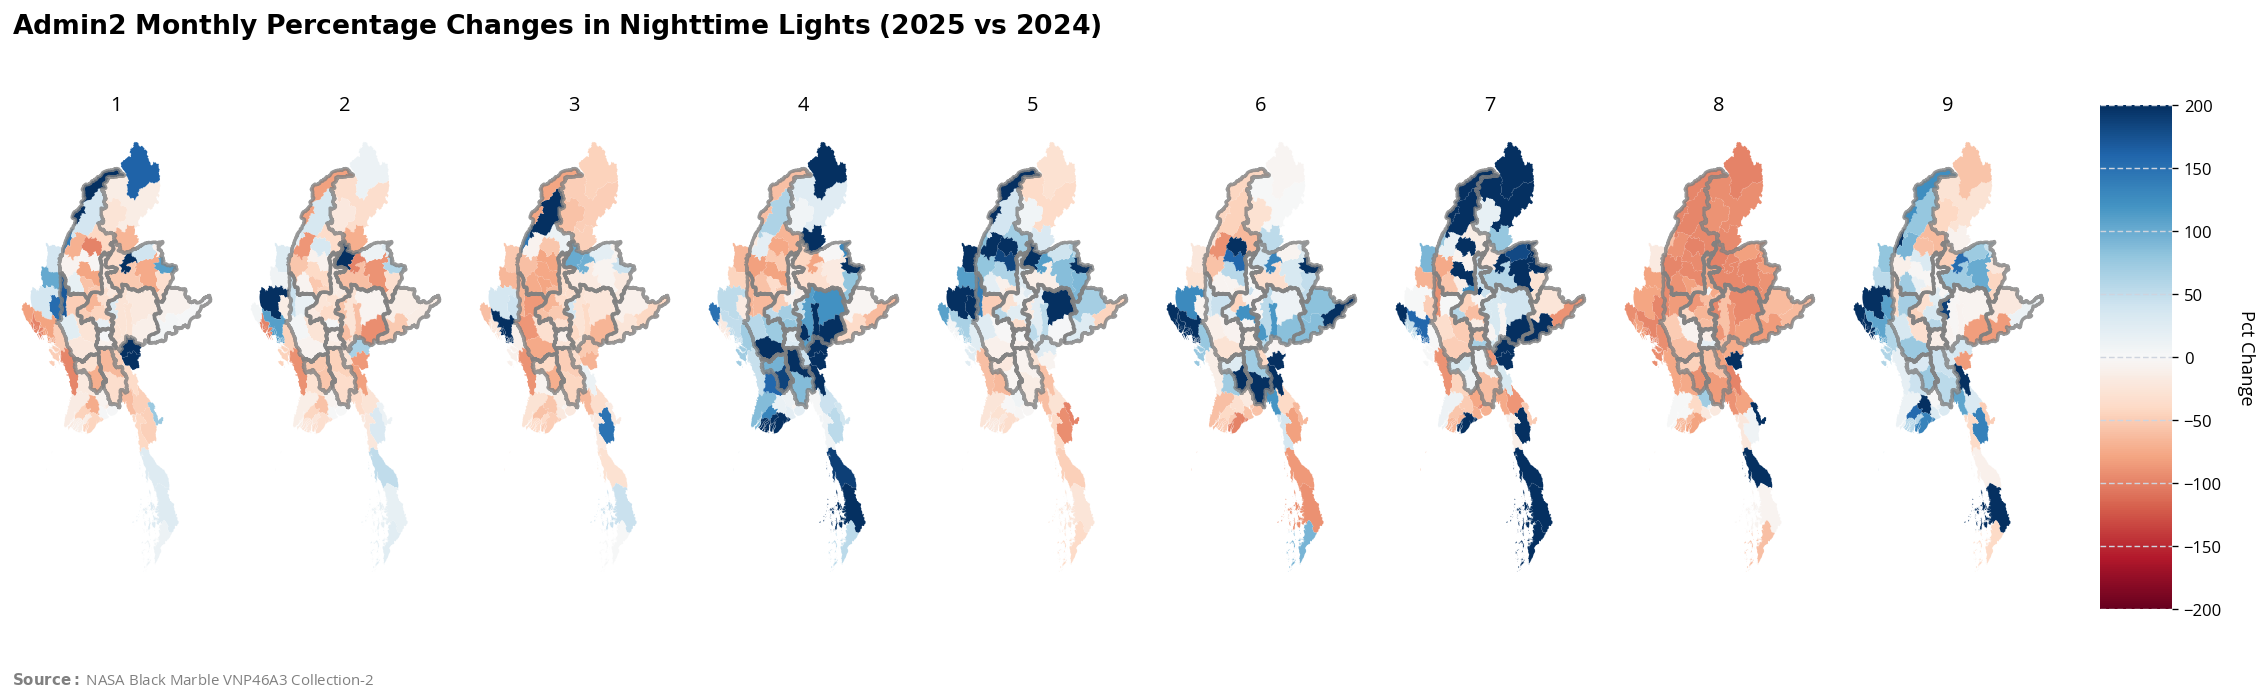

In [ ]:
monthly_pct_changes = subnational_monthly_pct_change(
    df=ntl_monthly_adm2,
    region_col="ADM2_EN",
    baseline_year=2024,
    current_year=2025,
    date_col="date",
)
monthly_pct_changes = mmr_adm2[["ADM2_EN", "geometry"]].merge(
    monthly_pct_changes, on="ADM2_EN", how="inner"
)


plot_maps_by_category(
    gdf=monthly_pct_changes,
    category_col="month",
    value_col="pct_change",
    cmap="RdBu",  # Red-Blue colormap, reversed (red=negative, blue=positive)
    figsize=(20, 6),
    ncols=9,
    suptitle="$\\mathbf{Admin2 \\ Monthly\\ Percentage\\ Changes\\ in\\ Nighttime\\ Lights\\ (2025\\ vs\\ 2024)}$",
    source_text="$\\mathbf{Source:}$ NASA Black Marble VNP46A3 Collection-2",
    legend=True,
    vmin=-200,  # Cap at -50%
    vmax=200,  # Cap at +200%
    boundary_gdf=mmr_adm1[mmr_adm1["ADM1_EN"].isin(most_impacted_regions)],
    boundary_kwargs={"color": "grey", "linewidth": 2.0, "alpha": 0.8},
)

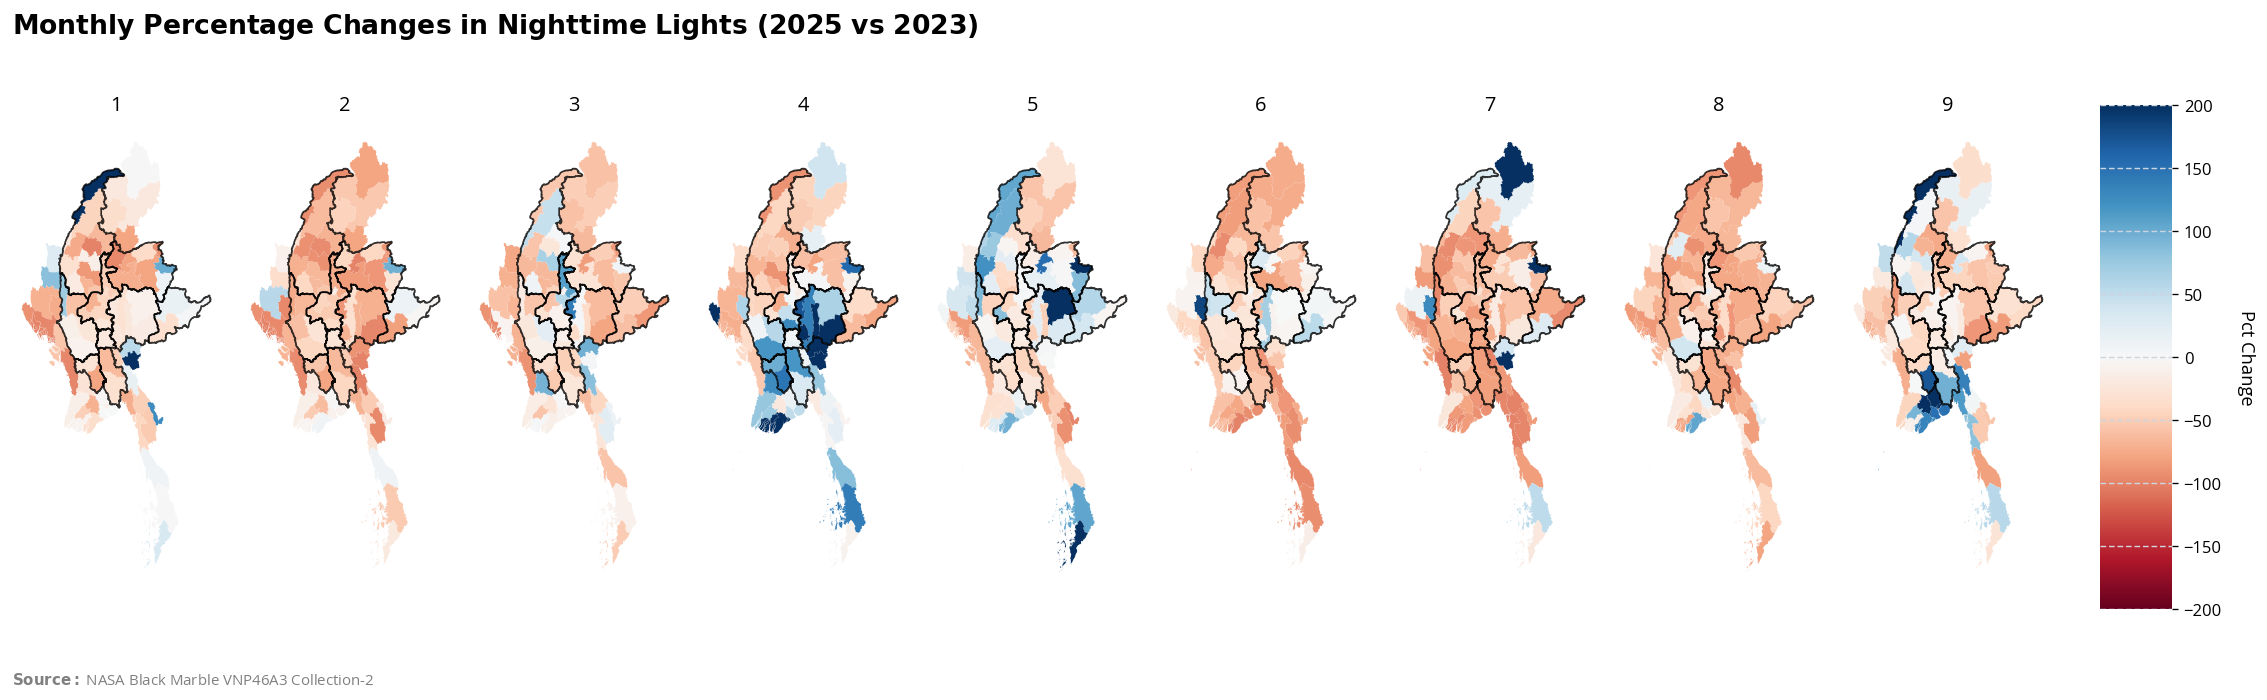

In [ ]:
monthly_pct_changes = subnational_monthly_pct_change(
    df=ntl_monthly_adm2,
    region_col="ADM2_EN",
    baseline_year=2023,
    current_year=2025,
    date_col="date",
)
monthly_pct_changes = mmr_adm2[["ADM2_EN", "geometry"]].merge(
    monthly_pct_changes, on="ADM2_EN", how="inner"
)


plot_maps_by_category(
    gdf=monthly_pct_changes,
    category_col="month",
    value_col="pct_change",
    cmap="RdBu",  # Red-Blue colormap, reversed (red=negative, blue=positive)
    figsize=(20, 6),
    ncols=9,
    suptitle="$\\mathbf{Monthly\\ Percentage\\ Changes\\ in\\ Nighttime\\ Lights\\ (2025\\ vs\\ 2023)}$",
    source_text="$\\mathbf{Source:}$ NASA Black Marble VNP46A3 Collection-2",
    legend=True,
    vmin=-200,  # Cap at -50%
    vmax=200,  # Cap at +200%
    boundary_gdf=mmr_adm1[mmr_adm1["ADM1_EN"].isin(most_impacted_regions)],
    boundary_kwargs={"color": "black", "linewidth": 1.0, "alpha": 0.8},
)

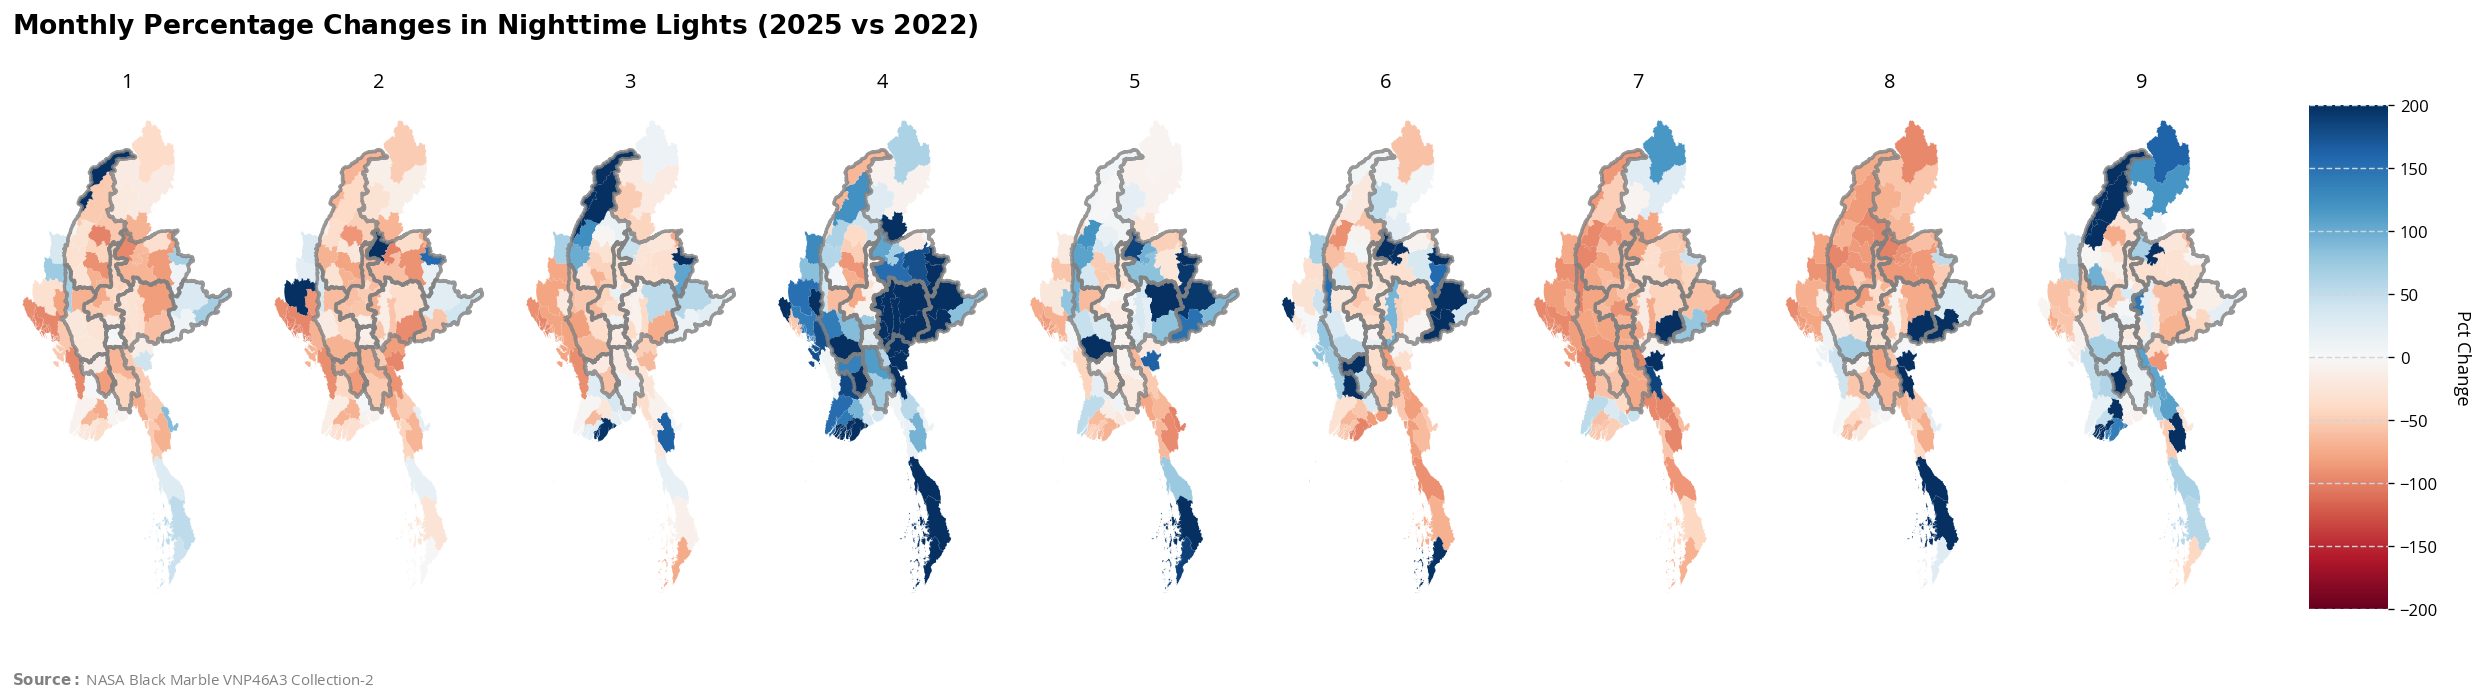

In [ ]:
monthly_pct_changes = subnational_monthly_pct_change(
    df=ntl_monthly_adm2,
    region_col="ADM2_EN",
    baseline_year=2022,
    current_year=2025,
    date_col="date",
)
monthly_pct_changes = mmr_adm2[["ADM2_EN", "geometry"]].merge(
    monthly_pct_changes, on="ADM2_EN", how="inner"
)

plot_maps_by_category(
    gdf=monthly_pct_changes,
    category_col="month",
    value_col="pct_change",
    cmap="RdBu",  # Red-Blue colormap, reversed (red=negative, blue=positive)
    figsize=(22, 6),
    ncols=9,
    suptitle="$\\mathbf{Monthly\\ Percentage\\ Changes\\ in\\ Nighttime\\ Lights\\ (2025\\ vs\\ 2022)}$",
    source_text="$\\mathbf{Source:}$ NASA Black Marble VNP46A3 Collection-2",
    legend=True,
    vmin=-200,  # Cap at -50%
    vmax=200,  # Cap at +200%
    boundary_gdf=mmr_adm1[mmr_adm1["ADM1_EN"].isin(most_impacted_regions)],
    boundary_kwargs={"color": "grey", "linewidth": 2.0, "alpha": 0.8},
)

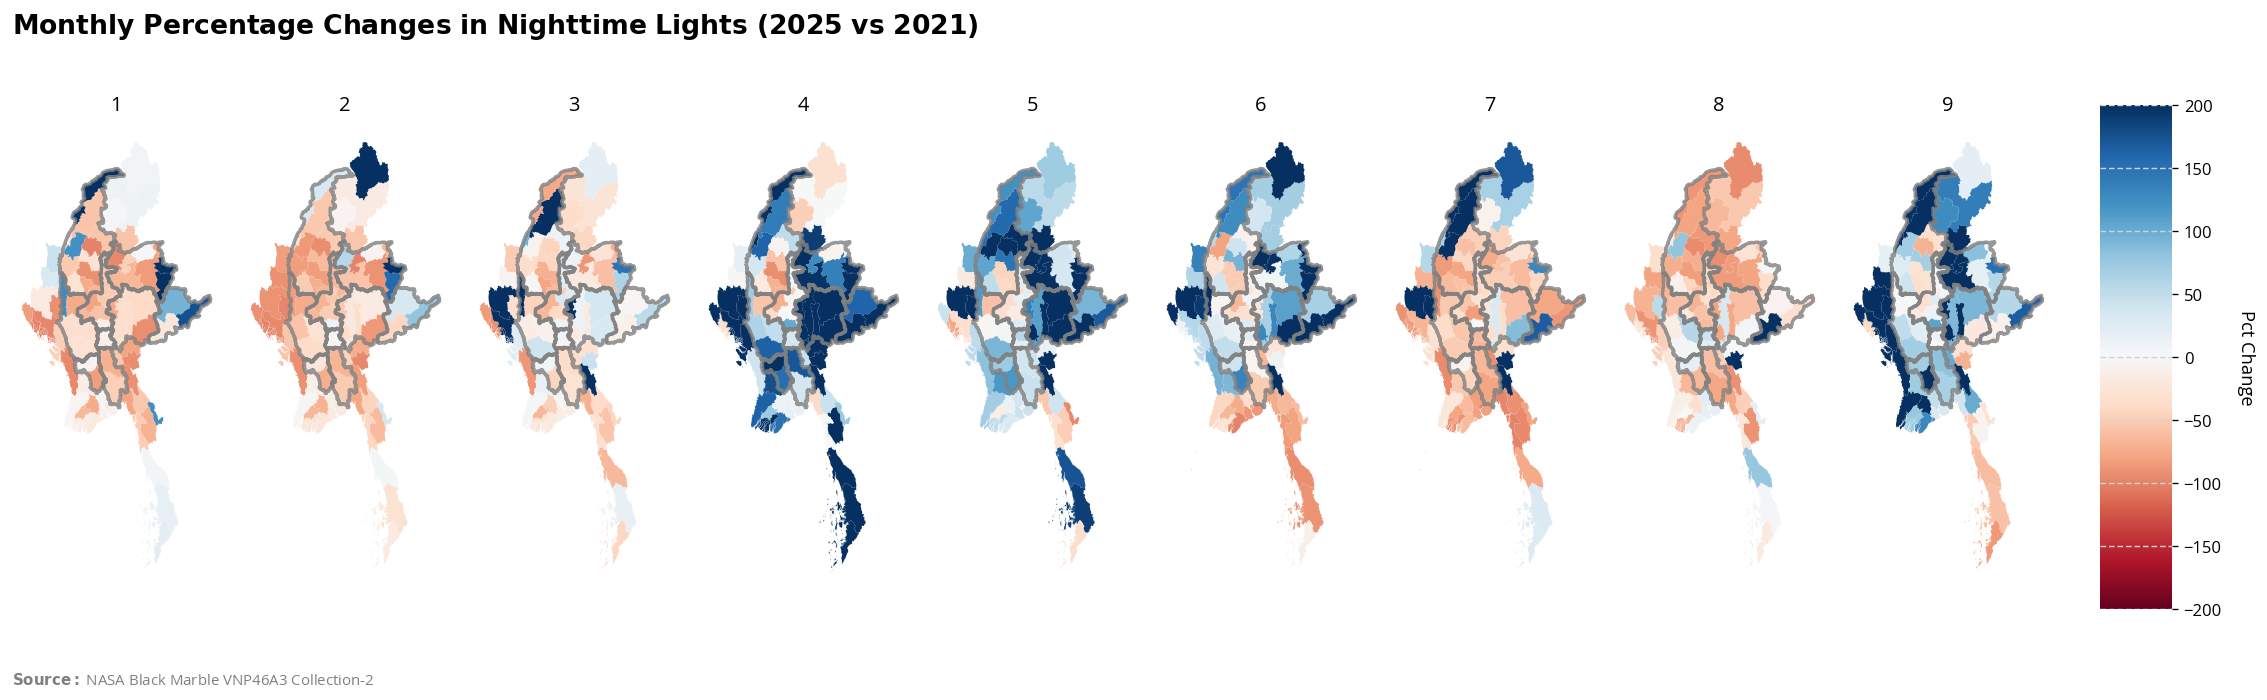

In [ ]:
monthly_pct_changes = subnational_monthly_pct_change(
    df=ntl_monthly_adm2,
    region_col="ADM2_EN",
    baseline_year=2021,
    current_year=2025,
    date_col="date",
)
monthly_pct_changes = mmr_adm2[["ADM2_EN", "geometry"]].merge(
    monthly_pct_changes, on="ADM2_EN", how="inner"
)

plot_maps_by_category(
    gdf=monthly_pct_changes,
    category_col="month",
    value_col="pct_change",
    cmap="RdBu",  # Red-Blue colormap, reversed (red=negative, blue=positive)
    figsize=(20, 6),
    ncols=9,
    suptitle="$\\mathbf{Monthly\\ Percentage\\ Changes\\ in\\ Nighttime\\ Lights\\ (2025\\ vs\\ 2021)}$",
    source_text="$\\mathbf{Source:}$ NASA Black Marble VNP46A3 Collection-2",
    legend=True,
    vmin=-200,  # Cap at -50%
    vmax=200,  # Cap at +200%
    boundary_gdf=mmr_adm1[mmr_adm1["ADM1_EN"].isin(most_impacted_regions)],
    boundary_kwargs={"color": "grey", "linewidth": 2.0, "alpha": 0.8},
)

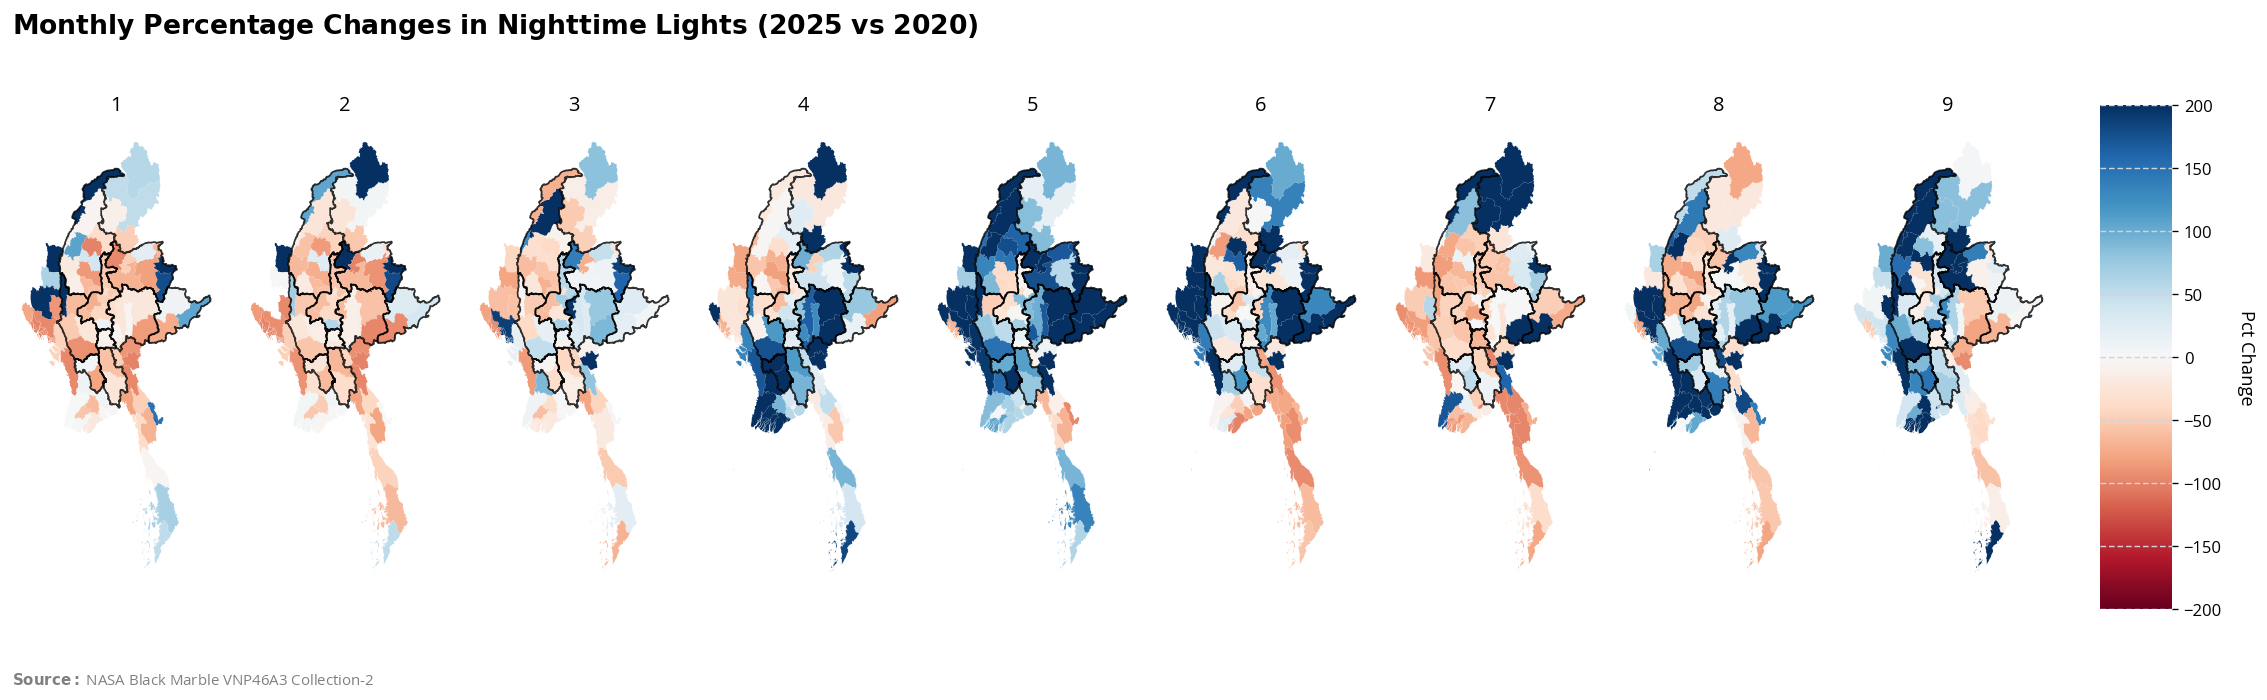

In [ ]:
monthly_pct_changes = subnational_monthly_pct_change(
    df=ntl_monthly_adm2,
    region_col="ADM2_EN",
    baseline_year=2020,
    current_year=2025,
    date_col="date",
)
monthly_pct_changes = mmr_adm2[["ADM2_EN", "geometry"]].merge(
    monthly_pct_changes, on="ADM2_EN", how="inner"
)


plot_maps_by_category(
    gdf=monthly_pct_changes,
    category_col="month",
    value_col="pct_change",
    cmap="RdBu",  # Red-Blue colormap, reversed (red=negative, blue=positive)
    figsize=(20, 6),
    ncols=9,
    suptitle="$\\mathbf{Monthly\\ Percentage\\ Changes\\ in\\ Nighttime\\ Lights\\ (2025\\ vs\\ 2020)}$",
    source_text="$\\mathbf{Source:}$ NASA Black Marble VNP46A3 Collection-2",
    legend=True,
    vmin=-200,  # Cap at -200%
    vmax=200,  # Cap at +200%
    boundary_gdf=mmr_adm1[mmr_adm1["ADM1_EN"].isin(most_impacted_regions)],
    boundary_kwargs={"color": "black", "linewidth": 1.0, "alpha": 0.8},
)

## Dive Dive into Bago and Shan

In [ ]:
import rasterio
import numpy as np

# Define the raw folder path
RAW_NTL_FOLDER = NTL_FOLDER / "raw"

# Get all TIFF files in the raw folder
tiff_files = glob.glob(str(RAW_NTL_FOLDER / "*.tif")) + glob.glob(
    str(RAW_NTL_FOLDER / "*.tiff")
)

print(f"Found {len(tiff_files)} TIFF files")
print("\nFirst 5 files:")
for file in tiff_files[:5]:
    print(f"  - {Path(file).name}")

# Example: Read a single TIFF file
if tiff_files:
    with rasterio.open(tiff_files[0]) as src:
        print(f"\n--- Info for: {Path(tiff_files[0]).name} ---")
        print(f"CRS: {src.crs}")
        print(f"Shape: {src.shape}")
        print(f"Bounds: {src.bounds}")
        print(f"Number of bands: {src.count}")

        # Read the first band
        band1 = src.read(1)
        print(f"Data type: {band1.dtype}")
        print(f"Min value: {np.nanmin(band1)}")
        print(f"Max value: {np.nanmax(band1)}")
        print(f"Mean value: {np.nanmean(band1)}")

Found 16 TIFF files

First 5 files:
  - VNP46A3.A2024061.h28v06.002.2025119195522.tif
  - VNP46A3.A2024092.h27v08.002.2025134112754.tif
  - VNP46A3.A2024061.h27v08.002.2025119195449.tif
  - VNP46A3.A2024092.h28v06.002.2025134112809.tif
  - VNP46A3.A2025091.h27v07.002.2025199134756.tif

--- Info for: VNP46A3.A2024061.h28v06.002.2025119195522.tif ---
CRS: EPSG:4326
Shape: (2400, 2400)
Bounds: BoundingBox(left=100.0001220703125, bottom=20.0001220703125, right=110.0001220703125, top=30.0001220703125)
Number of bands: 1
Data type: float64
Min value: 0.0
Max value: 8998.8740234375
Mean value: 0.6561656754395636


In [ ]:
# Find April 2024 and April 2025 files

# Filter for April files
# 2024092 represents April 2024 (day 092 of 2024)
# 2025091 represents April 2025 (day 091 of 2025)
april_2024_files = [f for f in tiff_files if "2024092" in Path(f).name]
april_2025_files = [f for f in tiff_files if "2025091" in Path(f).name]

print(f"April 2024 files found: {len(april_2024_files)}")
for f in april_2024_files:
    print(f"  - {Path(f).name}")

print(f"\nApril 2025 files found: {len(april_2025_files)}")
for f in april_2025_files:
    print(f"  - {Path(f).name}")

# Select the files for comparison
if april_2024_files and april_2025_files:
    file_2024 = april_2024_files[0]
    file_2025 = april_2025_files[0]
    print("\nUsing for comparison:")
    print(f"2024: {Path(file_2024).name}")
    print(f"2025: {Path(file_2025).name}")
else:
    print("\nWarning: Could not find both April 2024 and April 2025 files")

April 2024 files found: 4
  - VNP46A3.A2024092.h27v08.002.2025134112754.tif
  - VNP46A3.A2024092.h28v06.002.2025134112809.tif
  - VNP46A3.A2024092.h27v06.002.2025134112740.tif
  - VNP46A3.A2024092.h27v07.002.2025134112744.tif

April 2025 files found: 4
  - VNP46A3.A2025091.h27v07.002.2025199134756.tif
  - VNP46A3.A2025091.h28v06.002.2025199134833.tif
  - VNP46A3.A2025091.h27v08.002.2025199134654.tif
  - VNP46A3.A2025091.h27v06.002.2025199134618.tif

Using for comparison:
2024: VNP46A3.A2024092.h27v08.002.2025134112754.tif
2025: VNP46A3.A2025091.h27v07.002.2025199134756.tif


In [ ]:
# Create side-by-side comparison of April 2024 vs April 2025
if april_2024_files and april_2025_files:
    from rasterio.merge import merge

    # Mosaic all 2024 files
    print(f"Mosaicking {len(april_2024_files)} tiles for April 2024...")
    src_files_2024 = [rasterio.open(f) for f in april_2024_files]
    data_2024, transform_2024 = merge(src_files_2024)
    data_2024 = data_2024[0]  # Get first band

    # Get extent from transform
    height_2024, width_2024 = data_2024.shape
    extent_2024 = [
        transform_2024.c,  # left
        transform_2024.c + transform_2024.a * width_2024,  # right
        transform_2024.f + transform_2024.e * height_2024,  # bottom
        transform_2024.f,  # top
    ]

    # Close source files
    for src in src_files_2024:
        src.close()

    print(f"Combined April 2024 data shape: {data_2024.shape}")

    # Mosaic all 2025 files
    print(f"Mosaicking {len(april_2025_files)} tiles for April 2025...")
    src_files_2025 = [rasterio.open(f) for f in april_2025_files]
    data_2025, transform_2025 = merge(src_files_2025)
    data_2025 = data_2025[0]  # Get first band

    # Get extent from transform
    height_2025, width_2025 = data_2025.shape
    extent_2025 = [
        transform_2025.c,  # left
        transform_2025.c + transform_2025.a * width_2025,  # right
        transform_2025.f + transform_2025.e * height_2025,  # bottom
        transform_2025.f,  # top
    ]

    # Close source files
    for src in src_files_2025:
        src.close()

    print(f"Combined April 2025 data shape: {data_2025.shape}")

    # Mask the rasters to Myanmar boundary
    from rasterio.features import geometry_mask

    print("\nMasking rasters to Myanmar boundary...")

    # Ensure mmr_adm0 is in the same CRS as the raster (WGS84)
    if mmr_adm0.crs != "EPSG:4326":
        mmr_adm0_wgs84 = mmr_adm0.to_crs("EPSG:4326")
    else:
        mmr_adm0_wgs84 = mmr_adm0

    # Get the geometry
    shapes = [geom for geom in mmr_adm0_wgs84.geometry]

    # Create mask for 2024
    mask_2024 = geometry_mask(
        shapes, transform=transform_2024, invert=True, out_shape=data_2024.shape
    )
    data_2024_masked = np.where(mask_2024, data_2024, np.nan)

    # Create mask for 2025
    mask_2025 = geometry_mask(
        shapes, transform=transform_2025, invert=True, out_shape=data_2025.shape
    )
    data_2025_masked = np.where(mask_2025, data_2025, np.nan)

    print("Masking complete!")

Mosaicking 4 tiles for April 2024...
Combined April 2024 data shape: (7200, 4800)
Mosaicking 4 tiles for April 2025...
Combined April 2025 data shape: (7200, 4800)

Masking rasters to Myanmar boundary...
Combined April 2025 data shape: (7200, 4800)

Masking rasters to Myanmar boundary...
Masking complete!
Masking complete!


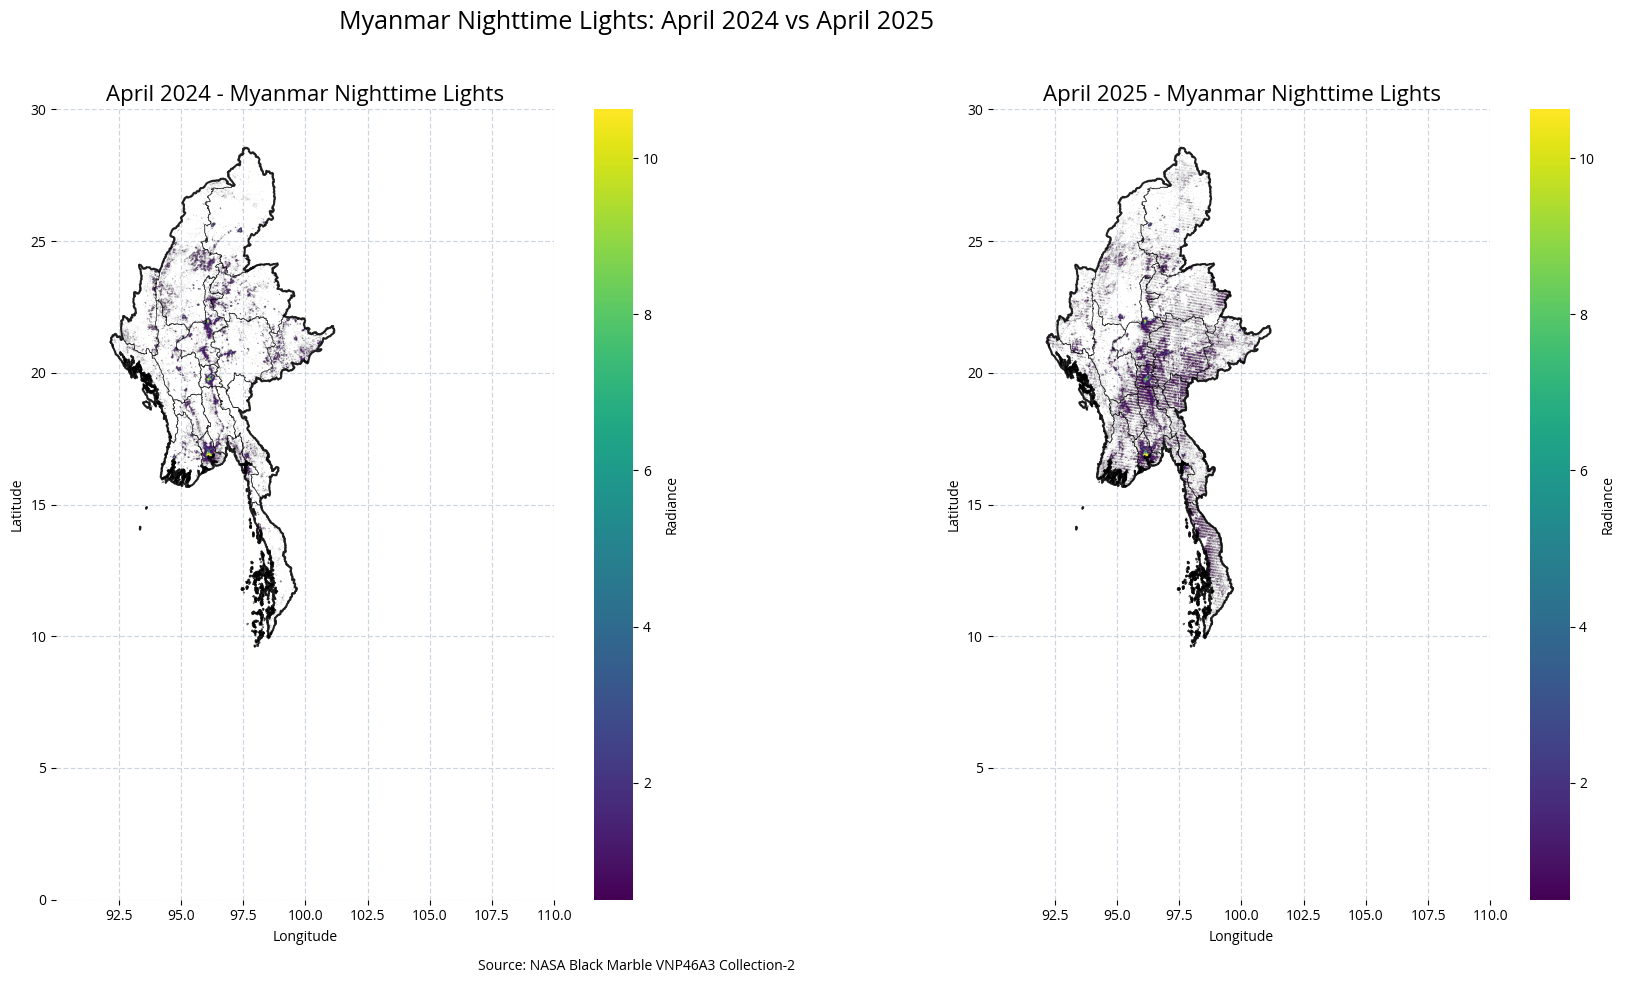


--- Statistics ---
April 2024: Mean=1.47, Max=450.42
April 2025: Mean=0.90, Max=987.33
Change: -38.69%
Change: -38.69%


In [ ]:
# Filter out near-zero values (set threshold)
threshold = 0.5  # Values below this will not be displayed
data_2024_filtered = np.where(data_2024_masked > threshold, data_2024_masked, np.nan)
data_2025_filtered = np.where(data_2025_masked > threshold, data_2025_masked, np.nan)

# Calculate common scale using 99th percentile across both datasets
combined_data = np.concatenate(
    [
        data_2024_filtered[~np.isnan(data_2024_filtered)],
        data_2025_filtered[~np.isnan(data_2025_filtered)],
    ]
)
vmin_common = threshold
vmax_common = np.nanpercentile(combined_data, 99)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot April 2024 (filtered)
im1 = axes[0].imshow(
    data_2024_filtered,
    cmap="viridis",
    extent=extent_2024,
    vmin=vmin_common,
    vmax=vmax_common,
)
axes[0].set_title(
    "April 2024 - Myanmar Nighttime Lights", fontsize=16, fontweight="bold"
)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Add Myanmar boundaries
mmr_adm0.boundary.plot(ax=axes[0], color="black", linewidth=1.5, alpha=0.8)
mmr_adm1.boundary.plot(ax=axes[0], color="black", linewidth=0.5, alpha=0.6)

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Radiance")

# Plot April 2025 (filtered)
im2 = axes[1].imshow(
    data_2025_filtered,
    cmap="viridis",
    extent=extent_2025,
    vmin=vmin_common,
    vmax=vmax_common,
)
axes[1].set_title(
    "April 2025 - Myanmar Nighttime Lights", fontsize=16, fontweight="bold"
)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# Add Myanmar boundaries
mmr_adm0.boundary.plot(ax=axes[1], color="black", linewidth=1.5, alpha=0.8)
mmr_adm1.boundary.plot(ax=axes[1], color="black", linewidth=0.5, alpha=0.6)

plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Radiance")

# Add overall title and source
fig.suptitle(
    "Myanmar Nighttime Lights: April 2024 vs April 2025",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)
fig.text(
    0.5,
    0.02,
    "Source: NASA Black Marble VNP46A3 Collection-2",
    ha="center",
    fontsize=10,
    style="italic",
)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Print statistics (using filtered data)
print("\n--- Statistics ---")
print(
    f"April 2024: Mean={np.nanmean(data_2024_filtered):.2f}, Max={np.nanmax(data_2024_filtered):.2f}"
)
print(
    f"April 2025: Mean={np.nanmean(data_2025_filtered):.2f}, Max={np.nanmax(data_2025_filtered):.2f}"
)
print(
    f"Change: {((np.nanmean(data_2025_filtered) - np.nanmean(data_2024_filtered)) / np.nanmean(data_2024_filtered) * 100):.2f}%"
)

## Comparison of March 2024 vs March 2025 Nighttime Lights

In [ ]:
# Find and process March 2024 and March 2025 files
# 2024061 represents March 2024 (day 061 of 2024)
# 2025060 represents March 2025 (day 060 of 2025)
march_2024_files = [f for f in tiff_files if "2024061" in Path(f).name]
march_2025_files = [f for f in tiff_files if "2025060" in Path(f).name]

print(f"March 2024 files found: {len(march_2024_files)}")
for f in march_2024_files:
    print(f"  - {Path(f).name}")

print(f"\nMarch 2025 files found: {len(march_2025_files)}")
for f in march_2025_files:
    print(f"  - {Path(f).name}")

# Process March data if files are found
if march_2024_files and march_2025_files:
    # Mosaic all 2024 March files
    print(f"\nMosaicking {len(march_2024_files)} tiles for March 2024...")
    src_files_march_2024 = [rasterio.open(f) for f in march_2024_files]
    data_march_2024, transform_march_2024 = merge(src_files_march_2024)
    data_march_2024 = data_march_2024[0]  # Get first band

    # Get extent from transform
    height_march_2024, width_march_2024 = data_march_2024.shape
    extent_march_2024 = [
        transform_march_2024.c,  # left
        transform_march_2024.c + transform_march_2024.a * width_march_2024,  # right
        transform_march_2024.f + transform_march_2024.e * height_march_2024,  # bottom
        transform_march_2024.f,  # top
    ]

    # Close source files
    for src in src_files_march_2024:
        src.close()

    print(f"Combined March 2024 data shape: {data_march_2024.shape}")

    # Mosaic all 2025 March files
    print(f"Mosaicking {len(march_2025_files)} tiles for March 2025...")
    src_files_march_2025 = [rasterio.open(f) for f in march_2025_files]
    data_march_2025, transform_march_2025 = merge(src_files_march_2025)
    data_march_2025 = data_march_2025[0]  # Get first band

    # Get extent from transform
    height_march_2025, width_march_2025 = data_march_2025.shape
    extent_march_2025 = [
        transform_march_2025.c,  # left
        transform_march_2025.c + transform_march_2025.a * width_march_2025,  # right
        transform_march_2025.f + transform_march_2025.e * height_march_2025,  # bottom
        transform_march_2025.f,  # top
    ]

    # Close source files
    for src in src_files_march_2025:
        src.close()

    print(f"Combined March 2025 data shape: {data_march_2025.shape}")

    # Mask the rasters to Myanmar boundary
    print("\nMasking rasters to Myanmar boundary...")

    # Create mask for March 2024
    mask_march_2024 = geometry_mask(
        shapes,
        transform=transform_march_2024,
        invert=True,
        out_shape=data_march_2024.shape,
    )
    data_march_2024_masked = np.where(mask_march_2024, data_march_2024, np.nan)

    # Create mask for March 2025
    mask_march_2025 = geometry_mask(
        shapes,
        transform=transform_march_2025,
        invert=True,
        out_shape=data_march_2025.shape,
    )
    data_march_2025_masked = np.where(mask_march_2025, data_march_2025, np.nan)

    print("Masking complete!")

    # Print statistics
    print("\n--- Statistics ---")
    print(
        f"March 2024: Mean={np.nanmean(data_march_2024_masked):.2f}, Max={np.nanmax(data_march_2024_masked):.2f}"
    )
    print(
        f"March 2025: Mean={np.nanmean(data_march_2025_masked):.2f}, Max={np.nanmax(data_march_2025_masked):.2f}"
    )
    print(
        f"Change: {((np.nanmean(data_march_2025_masked) - np.nanmean(data_march_2024_masked)) / np.nanmean(data_march_2024_masked) * 100):.2f}%"
    )
else:
    print("\nWarning: Could not find both March 2024 and March 2025 files")

March 2024 files found: 4
  - VNP46A3.A2024061.h28v06.002.2025119195522.tif
  - VNP46A3.A2024061.h27v08.002.2025119195449.tif
  - VNP46A3.A2024061.h27v06.002.2025119195449.tif
  - VNP46A3.A2024061.h27v07.002.2025119195448.tif

March 2025 files found: 4
  - VNP46A3.A2025060.h28v06.002.2025199125440.tif
  - VNP46A3.A2025060.h27v07.002.2025199125515.tif
  - VNP46A3.A2025060.h27v08.002.2025199125440.tif
  - VNP46A3.A2025060.h27v06.002.2025199125526.tif

Mosaicking 4 tiles for March 2024...
Combined March 2024 data shape: (7200, 4800)
Mosaicking 4 tiles for March 2025...
Combined March 2025 data shape: (7200, 4800)

Masking rasters to Myanmar boundary...
Combined March 2025 data shape: (7200, 4800)

Masking rasters to Myanmar boundary...
Masking complete!

--- Statistics ---
March 2024: Mean=0.14, Max=307.09
March 2025: Mean=0.08, Max=244.71
Change: -38.75%
Masking complete!

--- Statistics ---
March 2024: Mean=0.14, Max=307.09
March 2025: Mean=0.08, Max=244.71
Change: -38.75%


Using common scale: vmin=0.50, vmax=19.35


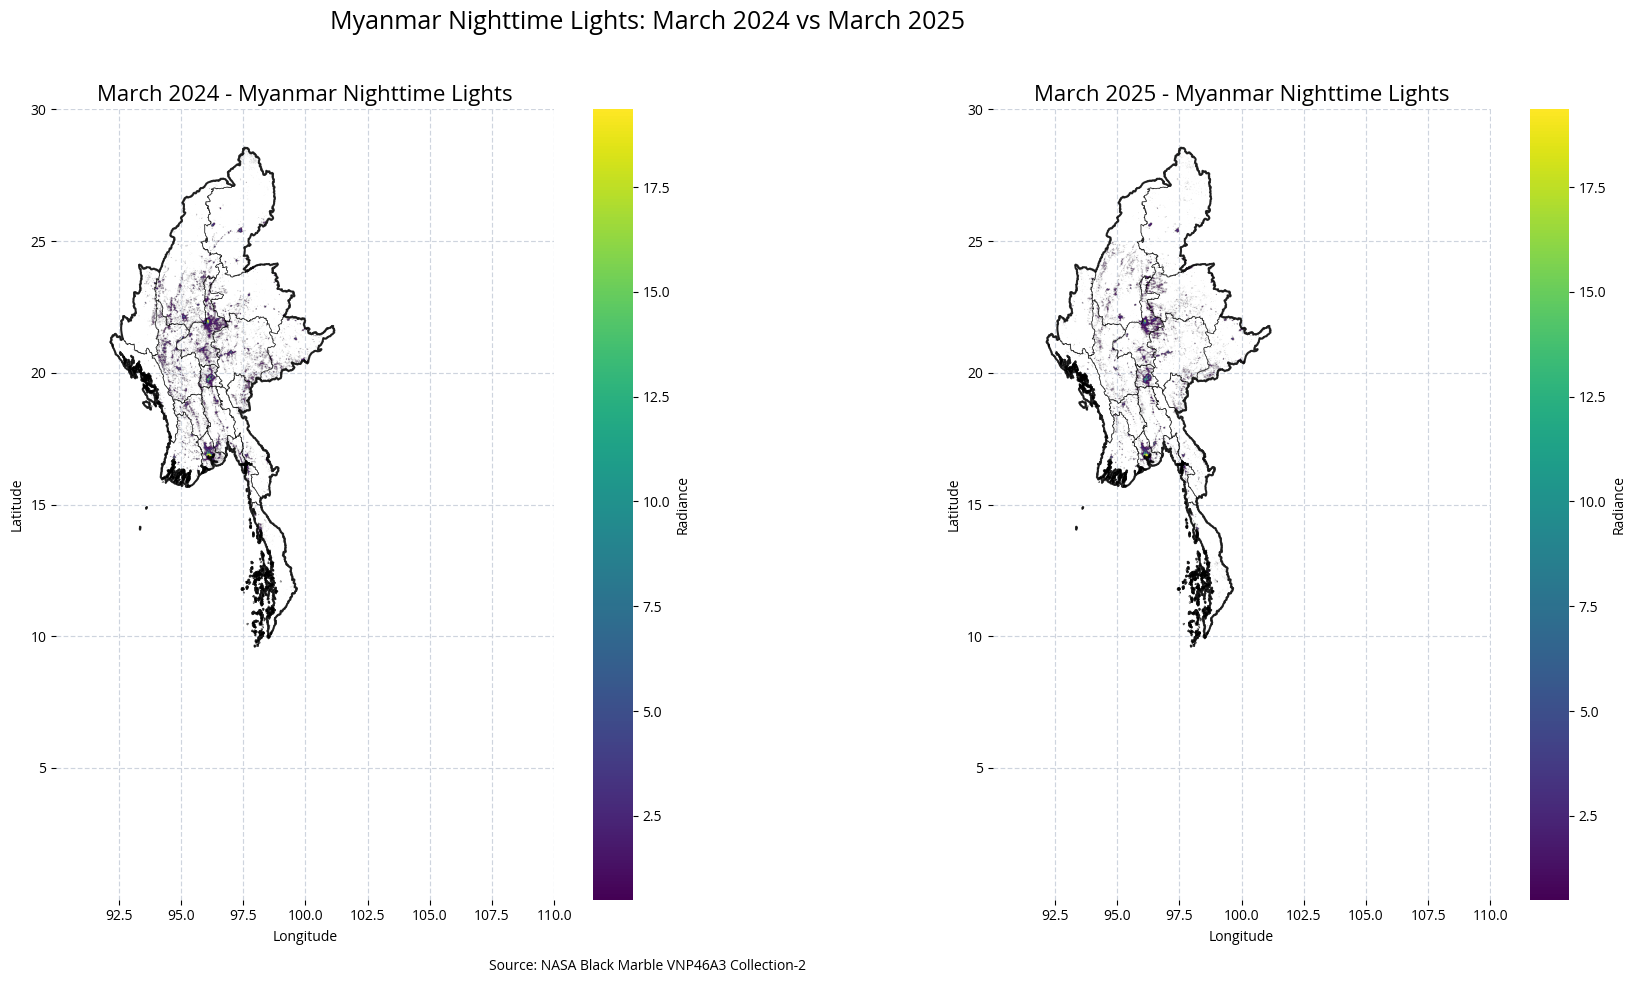

In [ ]:
# Plot March 2024 vs March 2025 comparison
if march_2024_files and march_2025_files:
    # Filter out near-zero values (set threshold)
    threshold = 0.5  # Values below this will not be displayed
    data_march_2024_filtered = np.where(
        data_march_2024_masked > threshold, data_march_2024_masked, np.nan
    )
    data_march_2025_filtered = np.where(
        data_march_2025_masked > threshold, data_march_2025_masked, np.nan
    )

    # Calculate common scale using 99th percentile across both datasets
    combined_data = np.concatenate(
        [
            data_march_2024_filtered[~np.isnan(data_march_2024_filtered)],
            data_march_2025_filtered[~np.isnan(data_march_2025_filtered)],
        ]
    )
    vmin_common = threshold
    vmax_common = np.nanpercentile(combined_data, 99)

    print(f"Using common scale: vmin={vmin_common:.2f}, vmax={vmax_common:.2f}")

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot March 2024 (filtered)
    im1 = axes[0].imshow(
        data_march_2024_filtered,
        cmap="viridis",
        extent=extent_march_2024,
        vmin=vmin_common,
        vmax=vmax_common,
    )
    axes[0].set_title(
        "March 2024 - Myanmar Nighttime Lights", fontsize=16, fontweight="bold"
    )
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    # Add Myanmar boundaries
    mmr_adm0.boundary.plot(ax=axes[0], color="black", linewidth=1.5, alpha=0.8)
    mmr_adm1.boundary.plot(ax=axes[0], color="black", linewidth=0.5, alpha=0.6)

    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Radiance")

    # Plot March 2025 (filtered)
    im2 = axes[1].imshow(
        data_march_2025_filtered,
        cmap="viridis",
        extent=extent_march_2025,
        vmin=vmin_common,
        vmax=vmax_common,
    )
    axes[1].set_title(
        "March 2025 - Myanmar Nighttime Lights", fontsize=16, fontweight="bold"
    )
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    # Add Myanmar boundaries
    mmr_adm0.boundary.plot(ax=axes[1], color="black", linewidth=1.5, alpha=0.8)
    mmr_adm1.boundary.plot(ax=axes[1], color="black", linewidth=0.5, alpha=0.6)

    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Radiance")

    # Add overall title and source
    fig.suptitle(
        "Myanmar Nighttime Lights: March 2024 vs March 2025",
        fontsize=18,
        fontweight="bold",
        y=0.98,
    )
    fig.text(
        0.5,
        0.02,
        "Source: NASA Black Marble VNP46A3 Collection-2",
        ha="center",
        fontsize=10,
        style="italic",
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()
else:
    print("Could not create comparison - files not found")

In [ ]:
# Import raster visualization utilities
from raster_visuals import mask_raster_to_boundary, calculate_common_scale

# Create masks for specific regions: Bago East (MMR111) and Shan South (MMR222)
target_regions = ["MMR111", "MMR222"]
mmr_target = mmr_adm1[mmr_adm1["ADM1_ALTPC"].isin(target_regions)].copy()

print("Selected regions:")
for idx, row in mmr_target.iterrows():
    print(f"  - {row['ADM1_EN']} ({row['ADM1_ALTPC']})")

# Process March data for target regions
if march_2024_files and march_2025_files:
    print("\nMasking March data to target regions...")

    # Mask March 2024
    data_march_2024_target_filtered = mask_raster_to_boundary(
        data_march_2024, transform_march_2024, mmr_target, threshold=0.5
    )

    # Mask March 2025
    data_march_2025_target_filtered = mask_raster_to_boundary(
        data_march_2025, transform_march_2025, mmr_target, threshold=0.5
    )

    # Calculate common scale for March
    vmin_target, vmax_target_march = calculate_common_scale(
        [data_march_2024_target_filtered, data_march_2025_target_filtered],
        threshold=0.5,
        percentile=99,
    )

    print(f"March common scale: vmin={vmin_target:.2f}, vmax={vmax_target_march:.2f}")

# Process April data for target regions
if april_2024_files and april_2025_files:
    print("\nMasking April data to target regions...")

    # Mask April 2024
    data_2024_target_filtered = mask_raster_to_boundary(
        data_2024, transform_2024, mmr_target, threshold=0.5
    )

    # Mask April 2025
    data_2025_target_filtered = mask_raster_to_boundary(
        data_2025, transform_2025, mmr_target, threshold=0.5
    )

    # Calculate common scale for April
    vmin_target, vmax_target_april = calculate_common_scale(
        [data_2024_target_filtered, data_2025_target_filtered],
        threshold=0.5,
        percentile=99,
    )
    combined_target_april = np.concatenate(
        [
            data_2024_target_filtered[~np.isnan(data_2024_target_filtered)],
            data_2025_target_filtered[~np.isnan(data_2025_target_filtered)],
        ]
    )
    vmax_target_april = np.nanpercentile(combined_target_april, 99)

    print(f"April common scale: vmin={vmin_target:.2f}, vmax={vmax_target_april:.2f}")

Selected regions:
  - Bago (East) (MMR111)
  - Bago (West) (MMR111)
  - Shan (East) (MMR222)
  - Shan (North) (MMR222)
  - Shan (South) (MMR222)

Masking March data to target regions...
March common scale: vmin=0.50, vmax=11.15

Masking April data to target regions...
March common scale: vmin=0.50, vmax=11.15

Masking April data to target regions...
April common scale: vmin=0.50, vmax=6.70
April common scale: vmin=0.50, vmax=6.70


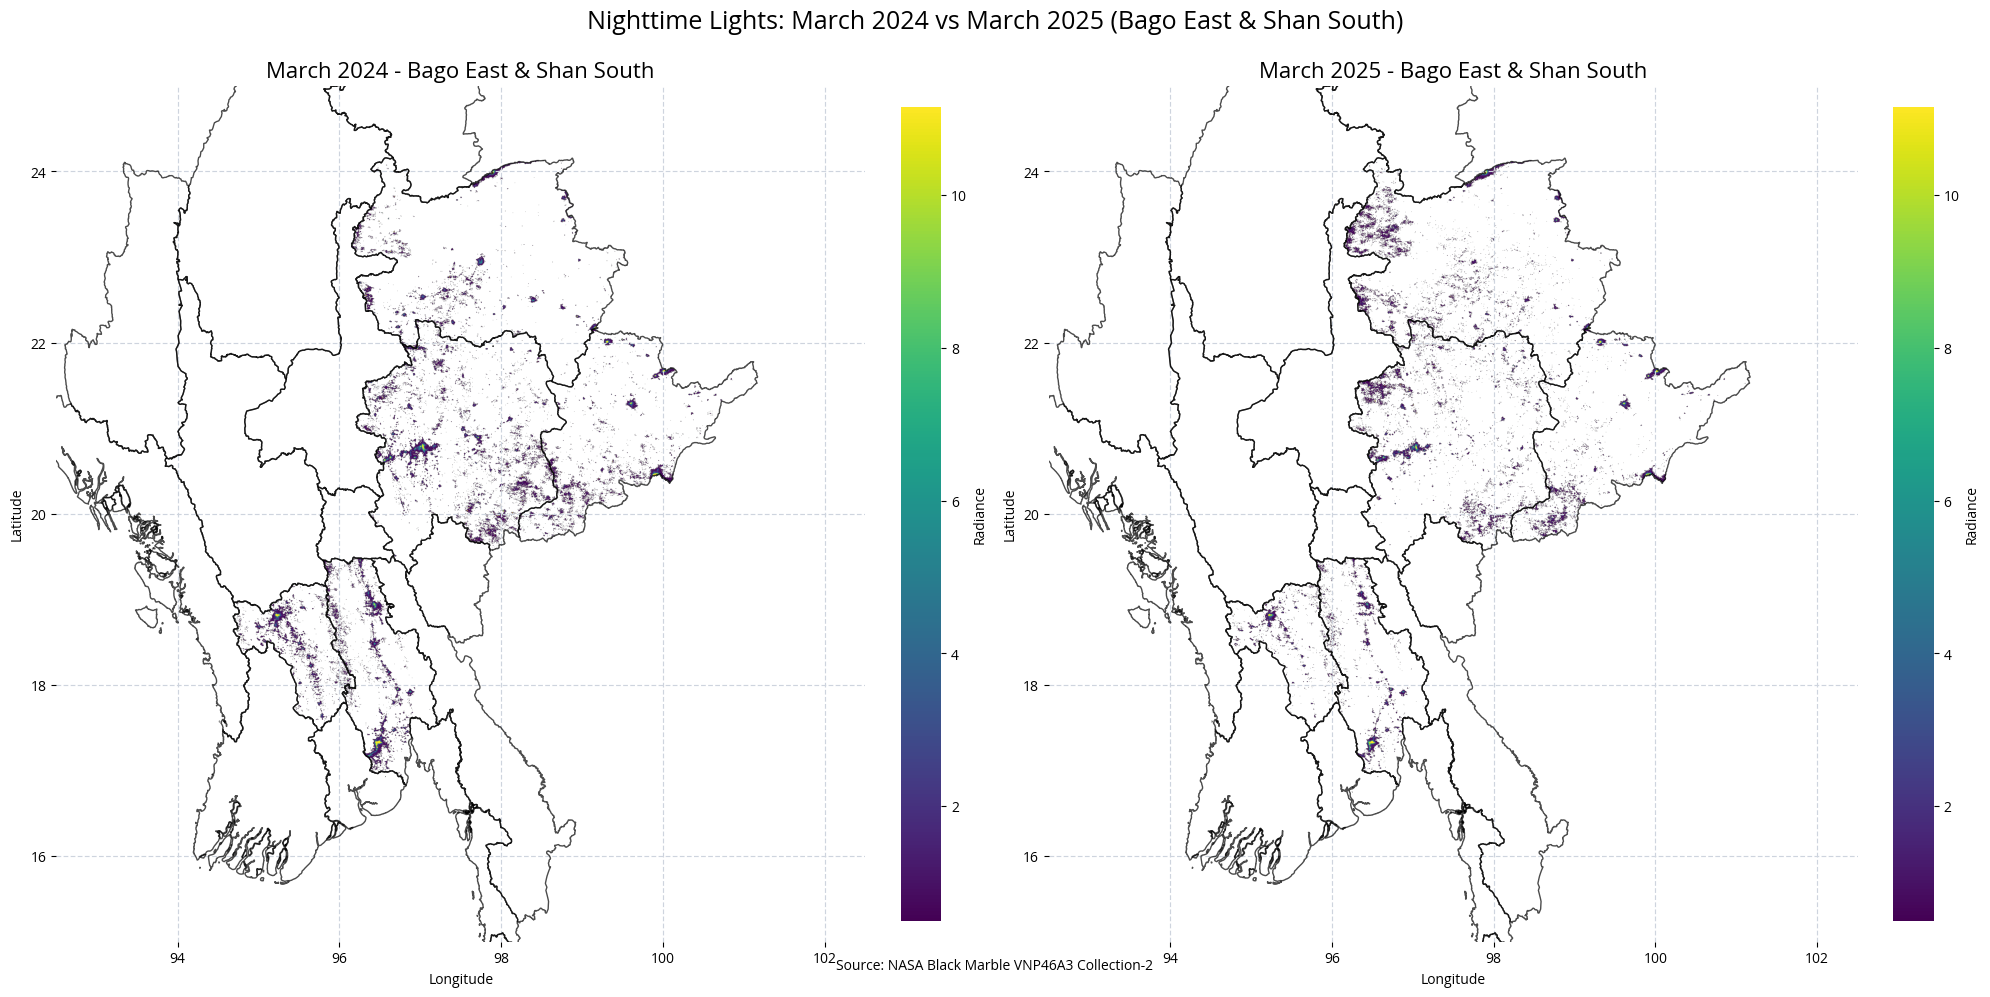


--- Statistics ---
March 2024: Mean=1.31, Max=307.09
March 2025: Mean=1.17, Max=179.61
Change: -10.63%


In [ ]:
# Plot March 2024 vs March 2025 for Bago East and Shan South
from raster_visuals import plot_raster_comparison, print_raster_statistics

if march_2024_files and march_2025_files:
    fig, axes = plot_raster_comparison(
        data1=data_march_2024_target_filtered,
        data2=data_march_2025_target_filtered,
        extent1=extent_march_2024,
        extent2=extent_march_2025,
        title1="March 2024 - Bago East & Shan South",
        title2="March 2025 - Bago East & Shan South",
        main_title="Nighttime Lights: March 2024 vs March 2025 (Bago East & Shan South)",
        vmin=vmin_target,
        vmax=vmax_target_march,
        boundary_gdf=mmr_adm1,  # Use full mmr_adm1 for context
        boundary_kwargs={"color": "black", "linewidth": 1.0, "alpha": 0.7},
        xlim=(92.5, 102.5),  # Zoom to specified longitude range
        ylim=(15, 25),  # Zoom to specified latitude range
        figsize=(20, 10),
        cmap="viridis",
    )
    plt.show()

    # Print statistics
    print_raster_statistics(
        data_march_2024_target_filtered,
        data_march_2025_target_filtered,
        "March 2024",
        "March 2025",
    )

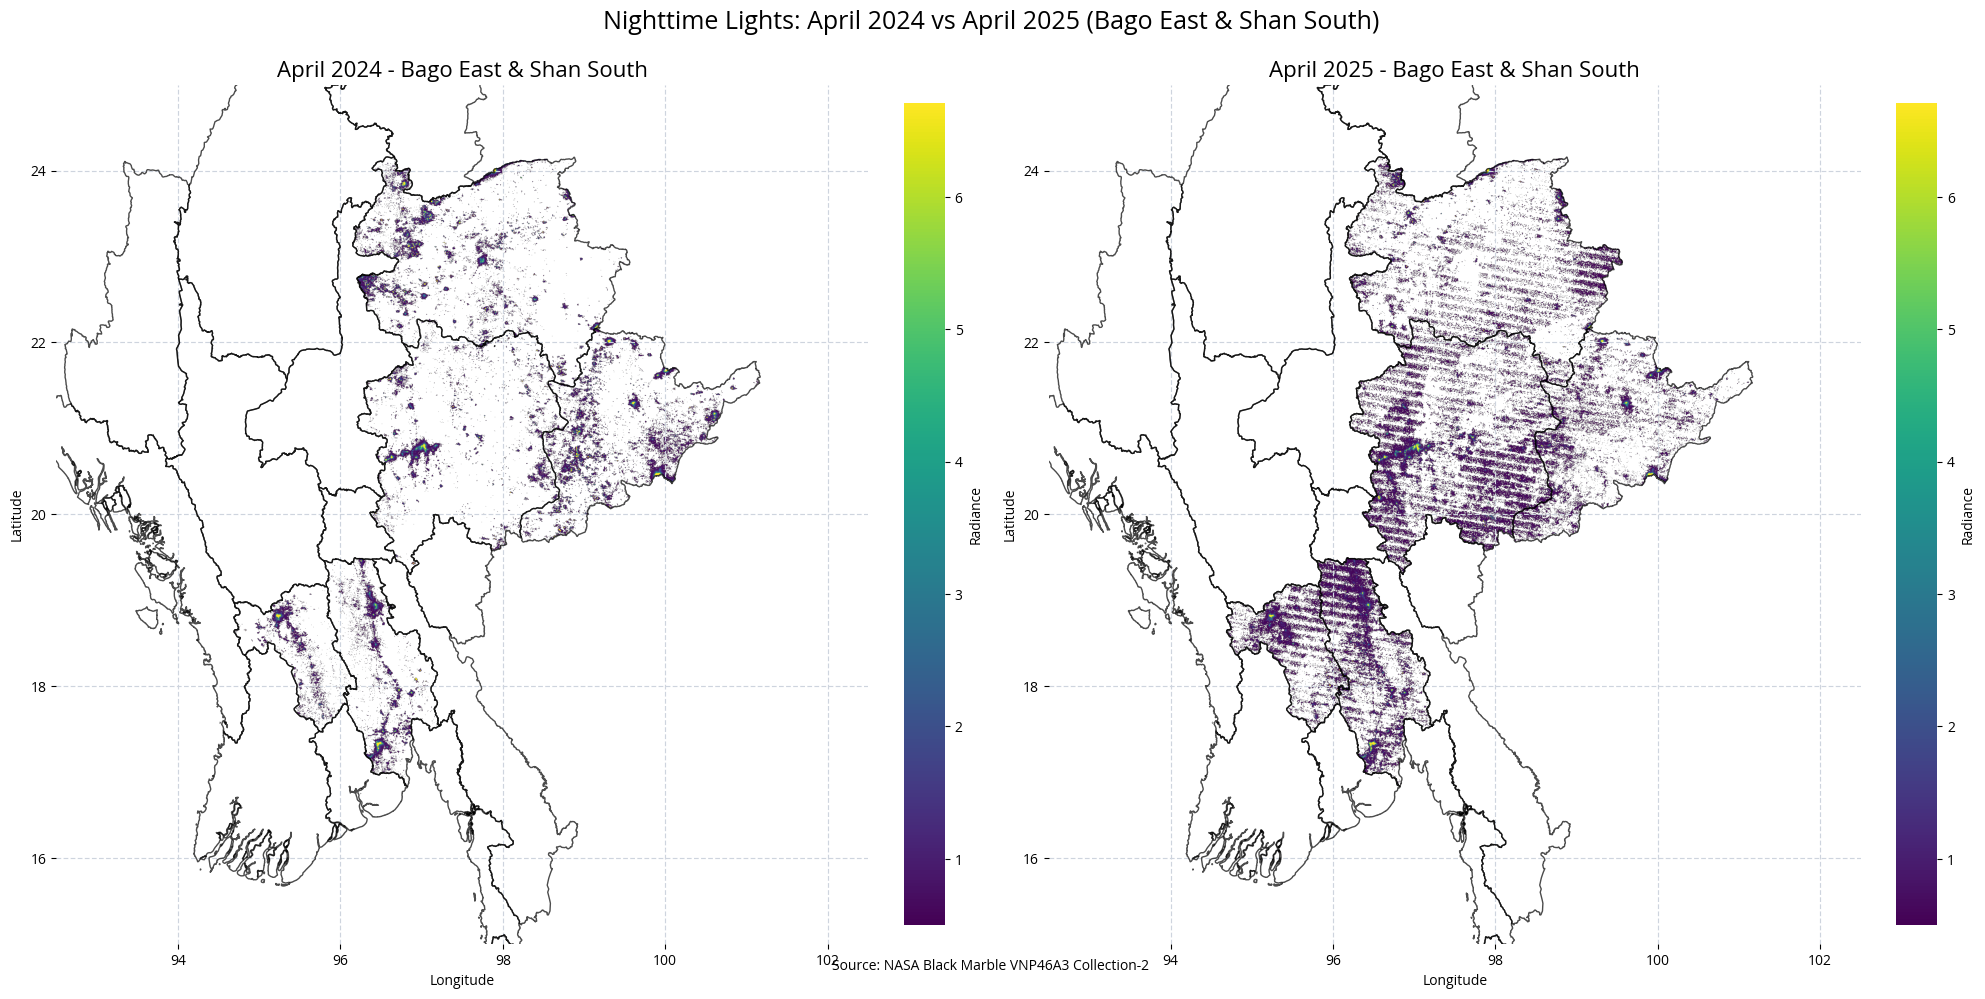


--- Statistics ---
April 2024: Mean=1.31, Max=450.42
April 2025: Mean=0.78, Max=295.77
Change: -40.77%

--- April Statistics (Bago East & Shan South) ---
April 2024: Mean=1.31, Max=450.42
April 2025: Mean=0.78, Max=295.77
Change: -40.77%
Change: -40.77%


In [ ]:
# Plot April 2024 vs April 2025 for Bago East and Shan South
if april_2024_files and april_2025_files:
    fig, axes = plot_raster_comparison(
        data1=data_2024_target_filtered,
        data2=data_2025_target_filtered,
        extent1=extent_2024,
        extent2=extent_2025,
        title1="April 2024 - Bago East & Shan South",
        title2="April 2025 - Bago East & Shan South",
        main_title="Nighttime Lights: April 2024 vs April 2025 (Bago East & Shan South)",
        vmin=vmin_target,
        vmax=vmax_target_april,
        boundary_gdf=mmr_adm1,  # Use full mmr_adm1 for context
        boundary_kwargs={"color": "black", "linewidth": 1.0, "alpha": 0.7},
        xlim=(92.5, 102.5),  # Zoom to specified longitude range
        ylim=(15, 25),  # Zoom to specified latitude range
        figsize=(20, 10),
        cmap="viridis",
    )
    plt.show()

    # Print statistics
    print_raster_statistics(
        data_2024_target_filtered, data_2025_target_filtered, "April 2024", "April 2025"
    )

    # Print statistics
    print("\n--- April Statistics (Bago East & Shan South) ---")
    print(
        f"April 2024: Mean={np.nanmean(data_2024_target_filtered):.2f}, Max={np.nanmax(data_2024_target_filtered):.2f}"
    )
    print(
        f"April 2025: Mean={np.nanmean(data_2025_target_filtered):.2f}, Max={np.nanmax(data_2025_target_filtered):.2f}"
    )
    print(
        f"Change: {((np.nanmean(data_2025_target_filtered) - np.nanmean(data_2024_target_filtered)) / np.nanmean(data_2024_target_filtered) * 100):.2f}%"
    )

In [349]:
ntl_daily_adm1 = pd.DataFrame()
for file in glob.glob("../../../data/ntl/collection2/daily/mmr_adm1_daily_*.csv"):
    df = pd.read_csv(file)
    ntl_daily_adm1 = pd.concat([ntl_daily_adm1, df])
ntl_daily_adm1.drop_duplicates(inplace=True)

ntl_daily_adm0 = pd.DataFrame()
for file in glob.glob("../../../data/ntl/collection2/daily/mmr_adm0_daily_*.csv"):
    df = pd.read_csv(file)
    ntl_daily_adm0 = pd.concat([ntl_daily_adm0, df])
ntl_daily_adm0.drop_duplicates(inplace=True)

# daily_2025 = pd.read_csv('../../../data/ntl/collection2/daily/mmr_adm1_daily_2025_09.csv')
# daily_2025

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': '$\\mathbf{Daily}$ Nightlights in 2025'}, xlabel='Year', ylabel='Luminosity'>)

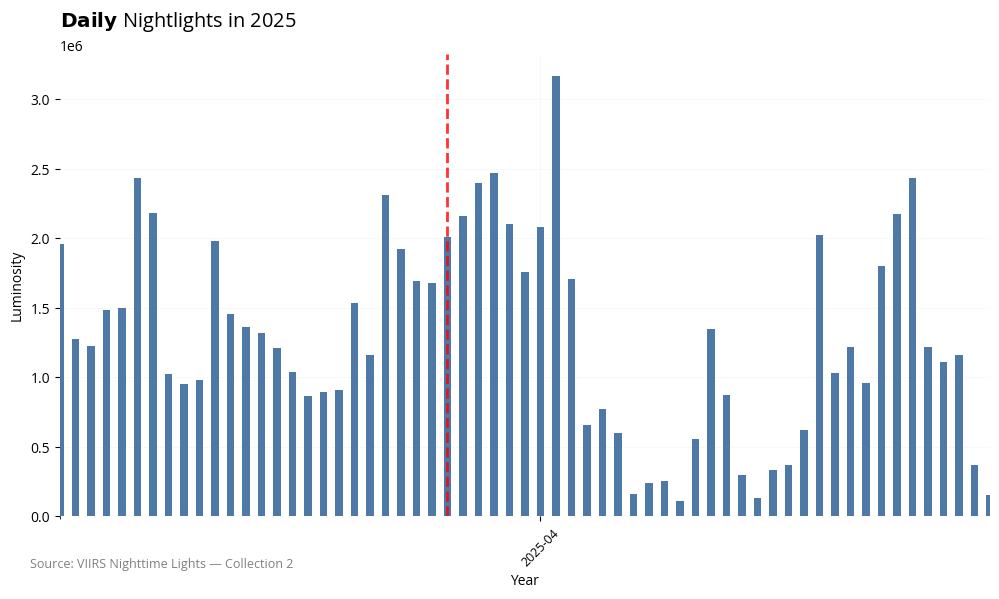

In [350]:
import visuals

ntl_daily_adm0["date"] = pd.to_datetime(ntl_daily_adm0["date"])
plot_bar_chart(
    df=ntl_daily_adm0.sort_values(by="date", ascending=True),
    x_col="date",  # Use year column directly instead of date
    value_col="ntl_sum",
    title="Daily Nightlights in 2025",
    xlabel="Year",
    ylabel="Luminosity",
    earthquake_marker="2025-03-26",
    date_col=None,  # No date column needed
    bar_width=0.5,  # Use relative width instead of absolute
    is_percentage=False,
)

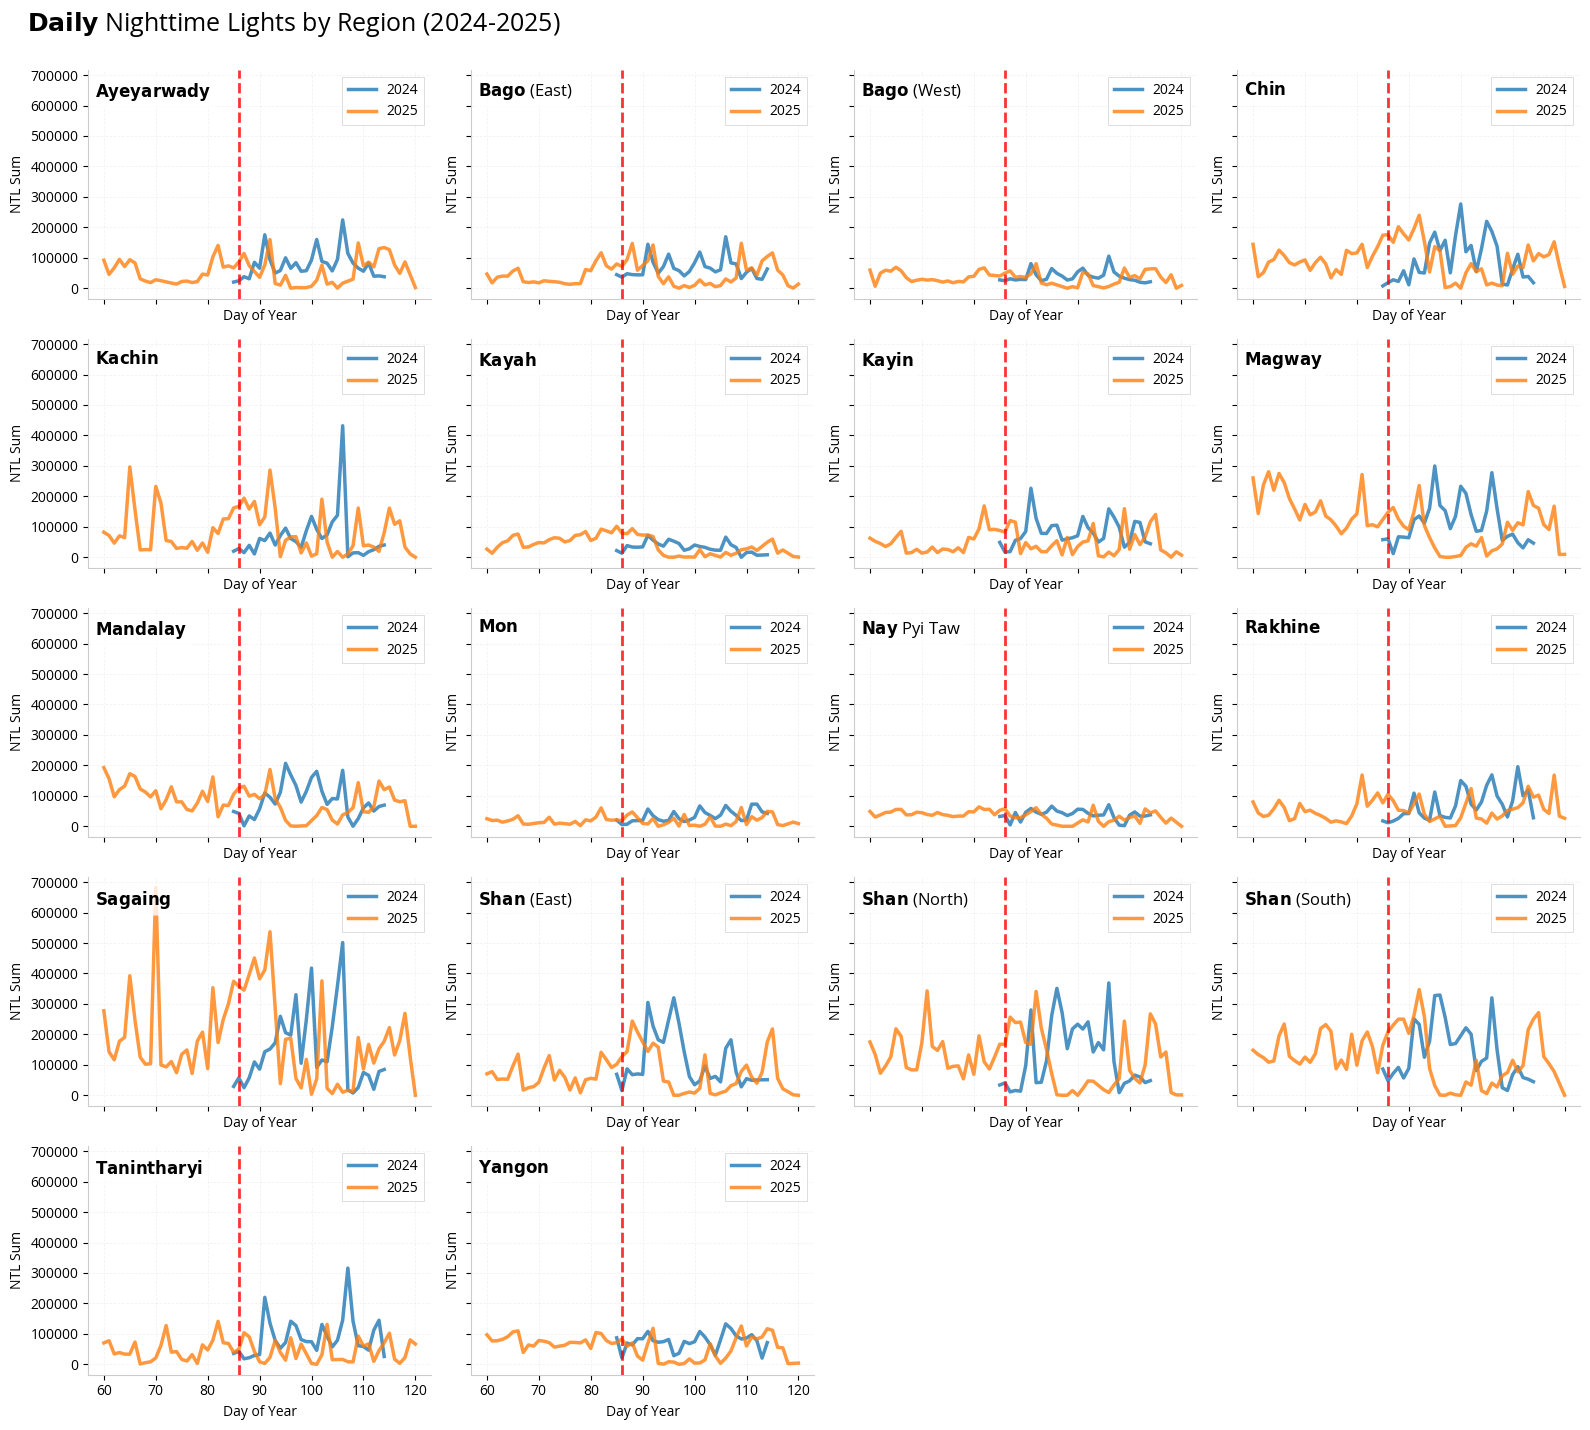

In [352]:
ntl_daily_adm1["date"] = pd.to_datetime(ntl_daily_adm1["date"])
ntl_daily_adm1["year_col"] = ntl_daily_adm1["date"].dt.year
ntl_daily_adm1["month"] = ntl_daily_adm1["date"].dt.month
ntl_daily_adm1["day"] = ntl_daily_adm1["date"].dt.day
ntl_daily_adm1["month_day"] = ntl_daily_adm1["date"].dt.strftime("%m-%d")

# Create a day_of_year column for proper chronological sorting within each year
ntl_daily_adm1["day_of_year"] = ntl_daily_adm1["date"].dt.dayofyear

# Filter for 2024-2025 comparison
ntl_regional_comparison = ntl_daily_adm1[
    (ntl_daily_adm1["year_col"].isin([2024, 2025]))
].copy()

# Sort by region, year, and day of year for proper chronological order
ntl_regional_comparison = ntl_regional_comparison.sort_values(
    by=["ADM1_EN", "year_col", "day_of_year"]
)

plot_comparative_lines_subplots(
    df=ntl_regional_comparison,
    category_col="ADM1_EN",  # Create subplots for each region
    x_col="day_of_year",  # X-axis: day of year (1-365) for proper chronological sorting
    value_col="ntl_sum",  # Y-axis: NTL sum
    group_col="year_col",  # Different lines for different years (2024 vs 2025)
    title="Daily Nighttime Lights by Region (2024-2025)",
    xlabel="Day of Year",
    ylabel="NTL Sum",
    date_col="date",
    ncols=4,  # 4 columns of subplots
    figsize_per_subplot=(4, 3),
    linewidth=2.5,
    marker_size=0,
    colors=["#1f77b4", "#ff7f0e"],  # Blue for 2024, Orange for 2025
    share_axes=True,
    earthquake_marker=86,  # Mark the earthquake date (March 25 = day 84)
);